#### imports

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings("ignore")

### Initial Data Preparation

#### helper functions

In [263]:
def shorten_model_name(name):
    name = name.replace("Qwen/Qwen2.5-VL-7B-Instruct", "Qwen7B")
    name = name.replace("OpenGVLab/InternVL3-8B", "Intern8B")
    name = name.replace("llava-hf/llava-v1.6-mistral-7b-hf", "LLaVA7B")
    name = name.replace("No judge model needed for this type of dataset.", "No judge")
    return name


def fill_correct(df, half_scores = False):
    df = df.copy()
    if half_scores:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right'
            else 0.5 if str(x).strip().lower() == 'somewhat right' 
            else 0
            )
    else:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right' 
            else 0
        )
    return df

def clean_df(df, subset_cols,):
    df = df.copy()
    df = df[df["judge_model_name"] != "Qwen2.5-VL-7B-Instruct"]
    df = df.dropna(subset=subset_cols).drop_duplicates(subset=subset_cols, keep='last')
    return df

def prepare_df(df, half_scores = False):
    df = df.copy()
    df = fill_correct(df, half_scores=half_scores)
    ensemble_subset_cols = [
            "problem_id",
            "dataset_name",
            "type_name",
            "version"
        ]
    
    single_subset_cols = [
            "problem_id",
            "dataset_name",
            "model_name",
            "strategy_name",
            "version"
        ]
    df_singles = df[df["ensemble"] == False]
    df_singles = clean_df(df_singles, subset_cols=single_subset_cols)
    df_ensembles = df[df["ensemble"] == True]
    df_ensembles = clean_df(df_ensembles, subset_cols=ensemble_subset_cols)
    return df_singles, df_ensembles

#### splitting data

In [ ]:
df = pd.read_csv('../sample_results/all_results_concat.csv')
df_ens_half = prepare_df(df, half_scores=True)[1]
df_ens_no_half = prepare_df(df, half_scores=False)[1]

df_sing_half = prepare_df(df, half_scores=True)[0]
df_sing_no_half = prepare_df(df, half_scores=False)[0]

##### preparing single csvs

In [265]:
df_clean = df_sing_half.dropna(axis=1)
df_clean["model_name"] = df_clean["model_name"].apply(shorten_model_name)

df_clean_no_test = df_clean[~df_clean["dataset_name"].str.contains("_test", na=False)]

summary = (
    df_clean_no_test
    .groupby(
        ["strategy_name", "dataset_name", "model_name", "version"],
        as_index=False
    )
    .agg(
        correct_sum=("is_correct", "sum"),
        total_count=("is_correct", "count")
    )
)

summary["avg_acc"] = summary["correct_sum"] / summary["total_count"]
summary = summary.drop(columns=["correct_sum","total_count"])
summary = summary.sort_values(by="avg_acc", ascending=False)

summary.to_csv("summary_aggregated_not_test_single.csv", index=False)

##### preparing ensemble csvs

In [266]:
df_clean = df_ens_half.dropna(axis=1).copy()
df_clean["model_name"] = df_clean["model_name"].apply(shorten_model_name)

summary = (
    df_clean
    .groupby(
        ["type_name", "dataset_name", "model_name", "ens_members_config_number", "seed", "version"],
        as_index=False
    )
    .agg(
        correct_sum=("is_correct", "sum"),
        total_count=("is_correct", "count")
    )
)

summary["accuracy"] = summary["correct_sum"] / summary["total_count"]
summary = summary.sort_values(by="accuracy", ascending=False)

summary["split"] = summary["dataset_name"].apply(
    lambda x: "test" if str(x).endswith("_test") else "original"
)
summary["dataset_name"] = summary["dataset_name"].str.replace("_test$", "", regex=True)

df_summary = (
    summary
    .groupby(
        ["type_name", "split", "dataset_name", "model_name", "ens_members_config_number"],
        as_index=False
    )
    .agg(
        avg_acc=("accuracy", "mean"),
        acc_count=("total_count", "sum")
    )
)

df_summary_sorted = df_summary.sort_values("avg_acc", ascending=False)

df_final = df_summary_sorted[df_summary_sorted["split"] != "test"].copy()
df_final = df_final.drop(columns=["split", "acc_count"])

df_final.to_csv("summary_aggregated_no_test.csv", index=False)

### Ensembles vs. Single statistics

#### preparing data for concatenation

In [267]:
df_ens_stat = pd.read_csv("summary_aggregated_no_test.csv")
df_ens_stat["configuration"] = (
    df_ens_stat["type_name"].astype(str) + "_" +
    df_ens_stat["model_name"].astype(str) + "_" +
    df_ens_stat["ens_members_config_number"].astype(str)
)

df_ens_stat = df_ens_stat.drop(columns=["type_name", "model_name", "ens_members_config_number"])
df_ens_stat["ensemble"]=True

In [268]:
df_single_stat = pd.read_csv("summary_aggregated_not_test_single.csv")
df_single_stat["configuration"] = (
    df_single_stat["strategy_name"].astype(str) + "_" +
    df_single_stat["model_name"].astype(str) + "_" +
    df_single_stat["version"].astype(str)
)

df_single_stat = df_single_stat.drop(columns=["strategy_name", "model_name", "version"])
df_single_stat["ensemble"]=False

#### function with results

Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dataset_name   332 non-null    object 
 1   avg_acc        332 non-null    float64
 2   configuration  332 non-null    object 
 3   ensemble       332 non-null    bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 8.2+ KB
None

--- One-way ANOVA Results ---
F-statistic: 13.1676
P-value: 3.2996e-04
Result: Statistically significant difference found (p < 0.05).

--- Detailed ANOVA Table ---
               sum_sq     df         F   PR(>F)
C(ensemble)  0.299610    1.0  13.16756  0.00033
Residual     7.508692  330.0       NaN      NaN


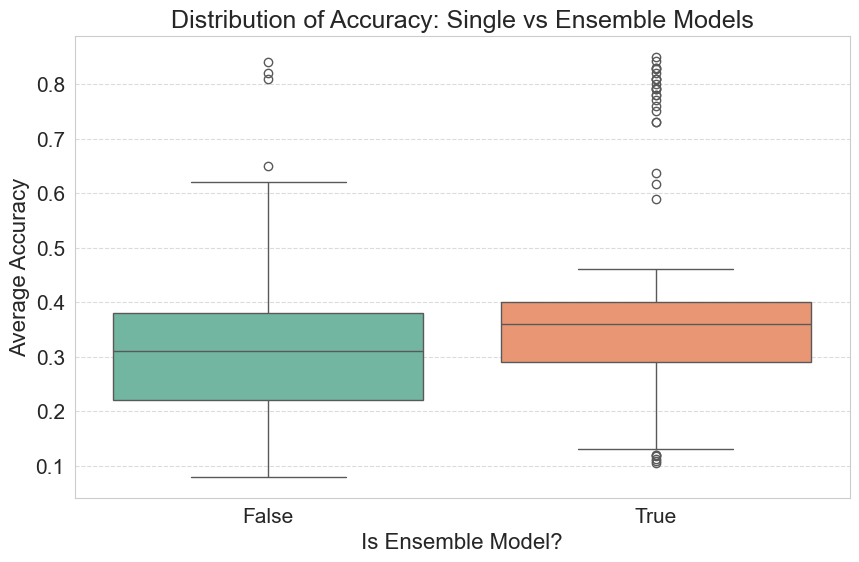

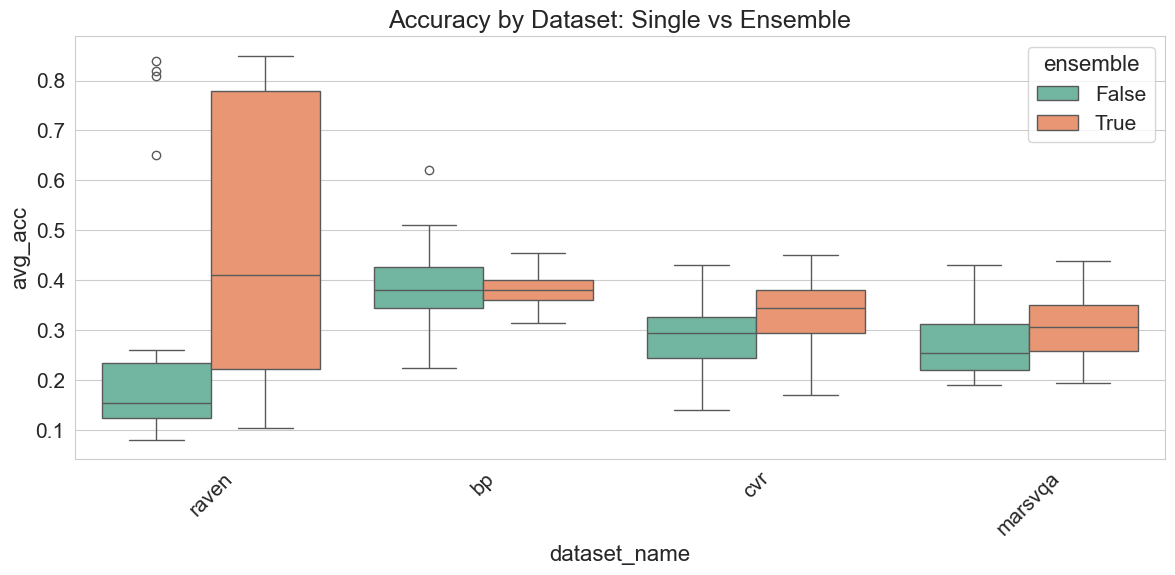

In [269]:
single = df_single_stat
ensemble = df_ens_stat

df = pd.concat([single, ensemble], ignore_index=True)

print("Combined Data Info:")
print(df.info())

# ANOVA TESTS
# Method A: One-way ANOVA using Scipy (Tests if means are different)
f_stat, p_value = stats.f_oneway(df[df['ensemble'] == False]['avg_acc'], 
                                 df[df['ensemble'] == True]['avg_acc'])

print("\n--- One-way ANOVA Results ---")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Result: Statistically significant difference found (p < 0.05).")
else:
    print("Result: No statistically significant difference found (p >= 0.05).")

# Method B: ANOVA Table using Statsmodels (More detailed)
# This model tests 'avg_acc' against 'ensemble'. 
# You can also use 'avg_acc ~ C(ensemble) + C(dataset_name)' to account for dataset difficulty.
model = ols('avg_acc ~ C(ensemble)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\n--- Detailed ANOVA Table ---")
print(anova_table)

# plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='ensemble', y='avg_acc', data=df, palette="Set2")
plt.title('Distribution of Accuracy: Single vs Ensemble Models')
plt.xlabel('Is Ensemble Model?')
plt.ylabel('Average Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

if 'dataset_name' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='dataset_name', y='avg_acc', hue='ensemble', data=df, palette="Set2")
    plt.title('Accuracy by Dataset: Single vs Ensemble')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

currently my ensemble and single frames contain data from all performed experiments, so it comes out that ensembles are significantly better, however it would make more sense to compare that way if the memebers of each ensemble were selected at random. In our methoology, ensembles were created from 1. top performing models overall, top performing models for each dataset, top performing strategy-model-version combinations. Therefore this needs adjustment

### Data Prep for Tables and Visualisations

#### functions

In [270]:
def add_ensemble_config_ids(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a column 'ensemble_config_ids' to the dataframe containing a list 
    of ensemble configuration IDs (0-8) that the row's configuration belongs to.
    """

    model_mapping = {
        'Qwen7B': 'Qwen/Qwen2.5-VL-7B-Instruct',
        'Intern8B': 'OpenGVLab/InternVL3-8B',
        'LLaVA7B': 'llava-hf/llava-v1.6-mistral-7b-hf'
    }

    def get_groups_for_row(row):
        strategy = row['strategy_name']
        dataset = row['dataset_name']
        long_model = model_mapping.get(row['model_name'], row['model_name'])
        seed = str(row['version']) 
        current_config = [strategy, long_model, seed]
        
        group_1_members = []
        d_lower = dataset.lower()

        if "bp" in d_lower and strategy == 'classification':
            return []
        
        if "bp" in d_lower:
            group_1_members = [
                ['direct', 'OpenGVLab/InternVL3-8B', '1'], 
                ['direct', 'OpenGVLab/InternVL3-8B', '3'], 
                ['descriptive', 'OpenGVLab/InternVL3-8B', '1'], 
                ['descriptive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1']
            ]
        elif d_lower == "cvr":
            group_1_members = [
                ['classification', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['direct', 'OpenGVLab/InternVL3-8B', '1'], 
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['classification', 'OpenGVLab/InternVL3-8B', '3']
            ]
        elif d_lower == "raven":
            group_1_members = [
                ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['contrastive', 'OpenGVLab/InternVL3-8B', '3']
            ]
        elif d_lower == "marsvqa":
            group_1_members = [
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], 
                ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], 
                ['descriptive', 'OpenGVLab/InternVL3-8B', '1']
            ]

        groups = {
            0: [['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['direct', 'OpenGVLab/InternVL3-8B', '1']], # top_members_overall
            1: group_1_members,
            2: [['classification', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['descriptive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3']], # qwen
            3: [['classification', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['contrastive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['descriptive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['direct', 'llava-hf/llava-v1.6-mistral-7b-hf', '1']], # llava
            4: [['classification', 'OpenGVLab/InternVL3-8B', '1'], ['contrastive', 'OpenGVLab/InternVL3-8B', '3'], ['descriptive', 'OpenGVLab/InternVL3-8B', '1'], ['direct', 'OpenGVLab/InternVL3-8B', '1']], # intern
            5: [['direct', 'OpenGVLab/InternVL3-8B', '1'], ['direct', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['direct', 'llava-hf/llava-v1.6-mistral-7b-hf', '1']], # direct
            6: [['descriptive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['descriptive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3'], ['descriptive', 'OpenGVLab/InternVL3-8B', '1']], # descriptive
            7: [['contrastive', 'OpenGVLab/InternVL3-8B', '3'], ['contrastive', 'Qwen/Qwen2.5-VL-7B-Instruct', '3'], ['contrastive', 'llava-hf/llava-v1.6-mistral-7b-hf', '3']], # contrastive
            8: [['classification', 'OpenGVLab/InternVL3-8B', '1'], ['classification', 'Qwen/Qwen2.5-VL-7B-Instruct', '1'], ['classification', 'llava-hf/llava-v1.6-mistral-7b-hf', '3']] # classification
        }

        member_of = []
        for group_id, members in groups.items():
            if current_config in members:
                member_of.append(group_id)
                
        return member_of

    df['ensemble_config_ids'] = df.apply(get_groups_for_row, axis=1)
    return df

In [271]:
def enrich_ensemble_with_single_stats(ensemble_df: pd.DataFrame, single_df: pd.DataFrame) -> pd.DataFrame:
    """
    Enriches the ensemble DataFrame with statistics about the single models that comprise each ensemble.
    
    Adds columns:
    - best_single_model: Strategy and Model name of the best performer.
    - best_single_acc: Accuracy of the best performer.
    - mean_single_acc: The mean accuracy of all models in the ensemble.
    - std_single_acc: The standard deviation of the models in the ensemble.
    """
    
    exploded_single = single_df.explode('ensemble_config_ids')
    exploded_single = exploded_single.dropna(subset=['ensemble_config_ids'])
    exploded_single['config_match_id'] = exploded_single['ensemble_config_ids'].astype(int)

    def get_group_stats(group):
        best_row = group.loc[group['avg_acc'].idxmax()]
        
        mean_val = group['avg_acc'].mean()
        std_val = group['avg_acc'].std()
        if pd.isna(std_val): std_val = 0.0
        
        best_name = f"{best_row['strategy_name']} - {best_row['model_name']} (v{best_row['version']})"
        
        return pd.Series({
            'best_single_model': best_name,
            'best_single_acc': round(best_row['avg_acc'], 4),
            'mean_single_acc': round(mean_val, 4),
            'std_single_acc': round(std_val, 4)
            })

    stats_df = exploded_single.groupby(['dataset_name', 'config_match_id']).apply(get_group_stats).reset_index()
    
    ensemble_df['config_match_id'] = ensemble_df['ens_members_config_number'].astype(int)

    merged_df = pd.merge(
        ensemble_df,
        stats_df,
        on=['dataset_name', 'config_match_id'],
        how='left'
    )
    
    merged_df.drop(columns=['config_match_id'], inplace=True)
    
    return merged_df

#### results

In [272]:
single_df = pd.read_csv('summary_aggregated_not_test_single.csv')
single_df = add_ensemble_config_ids(single_df)

ensemble_df = pd.read_csv("summary_aggregated_no_test.csv")
df = enrich_ensemble_with_single_stats(ensemble_df, single_df)

pattern = r'^(?P<best_strategy>[^-]+)\s*-\s*(?P<best_model>[^(]+)\s*\((?P<best_version>[^)]+)\)$'
extracted = df['best_single_model'].str.extract(pattern)

df = pd.concat([df, extracted], axis=1)

cols_to_strip = ['best_strategy', 'best_model', 'best_version']
for col in cols_to_strip:
    df[col] = df[col].str.strip()


### Ensemble Performace Summary Table & Statistics

#### functions

In [273]:
def generate_styled_dataset_tables(df):
    datasets = df['dataset_name'].unique()
    results = {}

    for ds in datasets:
        ds_df = df[df['dataset_name'] == ds].copy()

        ds_df['ens_members_config_number'] = ds_df['ens_members_config_number'].astype(int)
        ds_df['column_name'] = (
            ds_df['type_name'] + " (" + ds_df['model_name'] + ")"
        )

        pivot_table = ds_df.pivot_table(
            index='ens_members_config_number',
            columns='column_name',
            values='avg_acc'
        )

        best_single = ds_df.pivot_table(
            index='ens_members_config_number',
            columns='column_name',
            values='best_single_acc'
        )

        mean_single = ds_df.pivot_table(
            index='ens_members_config_number',
            columns='column_name',
            values='mean_single_acc'
        )

        pivot_table = pivot_table.sort_index(axis=0).sort_index(axis=1)
        best_single = best_single.reindex_like(pivot_table)
        mean_single = mean_single.reindex_like(pivot_table)

        def highlight_performance(data, mean_baseline, best_baseline):
            """
            data: The main DataFrame being styled.
            mean_baseline: DataFrame for element-wise comparison.
            best_baseline: DataFrame for element-wise AND global max comparison.
            """
            styles = pd.DataFrame('', index=data.index, columns=data.columns)

            gt_mean = data > mean_baseline
            gt_best = data > best_baseline

            global_max_val = best_baseline.values.max()
            gt_global_max = data > global_max_val

            # bold if > mean_single (element-wise)
            styles[gt_mean] += 'font-weight: bold; '

            # green background if > best_single (element-wise)
            styles[gt_best] += 'background-color: #a7ed51; '

            # blue frame if > global max of best_single
            styles[gt_global_max] += 'border: 3px solid #48a6fe; '

            return styles

        styled_pivot = pivot_table.style.apply(
            highlight_performance, 
            axis=None, 
            mean_baseline=mean_single, 
            best_baseline=best_single
        ).format("{:.4f}")

        results[ds] = {
            'main_avg_acc': styled_pivot,
            'best_single_baseline': best_single,
            'mean_single_baseline': mean_single,
        }

    return results

In [274]:
def analyze_ensemble_statistics(results_dict):
    """
    Analyzes the styling results to calculate improvement statistics.
    
    Args:
        results_dict (dict): The output from generate_styled_dataset_tables.
        
    Returns:
        dict: A dictionary containing 'overall', 'by_model', and 'by_config' 
              statistics for each dataset.
    """
    analysis_report = {}

    for ds_name, data in results_dict.items():
        df_main = data['main_avg_acc'].data 
        df_mean = data['mean_single_baseline']
        df_best = data['best_single_baseline']

        df_mean = df_mean.reindex_like(df_main)
        df_best = df_best.reindex_like(df_main)

        # better than average
        mask_gt_avg = df_main > df_mean
        
        # better than best single
        mask_gt_best = df_main > df_best
        
        # better than global best
        global_max_val = df_best.values.max()
        mask_gt_global = df_main > global_max_val

        def calc_stat(mask_subset):
            count = mask_subset.sum().sum()
            total = mask_subset.size
            pct = (count / total * 100) if total > 0 else 0.0
            return count, pct, f"{count} ({pct:.1f}%)"

        total_configs = df_main.size
        _, _, str_gt_avg = calc_stat(mask_gt_avg)
        _, _, str_gt_best = calc_stat(mask_gt_best)
        _, _, str_gt_global = calc_stat(mask_gt_global)

        overall_stats = {
            'Total Configs Tested': total_configs,
            'Better > Average (Bold)': str_gt_avg,
            'Better > Best Single (Green)': str_gt_best,
            'Better > Global Best (Blue Frame)': str_gt_global
        }

        targets = ['Intern8B', 'Qwen7B', 'No judge']
        model_rows = []

        for target in targets:
            cols = [c for c in df_main.columns if target.lower() in c.lower()]
            
            if not cols:
                continue
            _, _, m_avg = calc_stat(mask_gt_avg[cols])
            _, _, m_best = calc_stat(mask_gt_best[cols])
            _, _, m_global = calc_stat(mask_gt_global[cols])
            
            model_rows.append({
                'Model Group': target,
                'Count': len(cols) * df_main.shape[0], 
                '> Avg (Bold)': m_avg,
                '> Best (Green)': m_best,
                '> Global (Blue)': m_global
            })

        df_model_stats = pd.DataFrame(model_rows)

        config_rows = []
        for idx in df_main.index:
            _, _, c_avg = calc_stat(mask_gt_avg.loc[[idx]])
            _, _, c_best = calc_stat(mask_gt_best.loc[[idx]])
            _, _, c_global = calc_stat(mask_gt_global.loc[[idx]])
            
            config_rows.append({
                'Config Num': idx,
                '> Avg (Bold)': c_avg,
                '> Best (Green)': c_best,
                '> Global (Blue)': c_global
            })

        df_config_stats = pd.DataFrame(config_rows)

        analysis_report[ds_name] = {
            'overall': overall_stats,
            'by_model': df_model_stats,
            'by_config': df_config_stats
        }

    return analysis_report

#### results  

bold - better than mean of internal members  
green - better than best of internal members  
blue square - bettar than global best single for dataset  

In [275]:
all_results = generate_styled_dataset_tables(df)

data = all_results['bp']
display(data['main_avg_acc'])

column_name,confidence (Intern8B),confidence (Qwen7B),majority (Intern8B),majority (Qwen7B),reasoning (Intern8B),reasoning (Qwen7B),reasoning_with_image (Intern8B),reasoning_with_image (Qwen7B)
ens_members_config_number,,,,,,,,
0,0.4000,0.3700,0.3850,0.3700,0.3800,0.3950,0.4150,0.3950
1,0.4250,0.4450,0.4200,0.3950,0.4000,0.4400,0.4350,0.4550
2,0.3600,0.3650,0.3700,0.3650,0.3800,0.4000,0.3850,0.4250
3,0.3350,0.3700,0.3150,0.3650,0.3400,0.3650,0.3550,0.3900
4,0.3600,0.4150,0.3450,0.3850,0.3500,0.3850,0.3850,0.4150
5,0.3650,0.4150,0.3400,0.3500,0.3500,0.3800,0.3900,0.3650
6,0.4050,0.3800,0.4050,0.3900,0.4150,0.3850,0.3750,0.3950
7,0.3750,0.3600,0.3450,0.3400,0.3300,0.3550,0.3400,0.3900


In [276]:
stats = analyze_ensemble_statistics(all_results)

dataset_name = df['dataset_name'].unique()[0]

print(f"--- Analysis for {dataset_name} ---")
print("\nOVERALL STATS:")
for k, v in stats[dataset_name]['overall'].items():
    print(f"{k}: {v}")

print("\nBY MODEL (Judge):")
display(stats[dataset_name]['by_model'])

print("\nBY CONFIG NUMBER:")
display(stats[dataset_name]['by_config'])

--- Analysis for raven ---

OVERALL STATS:
Total Configs Tested: 54
Better > Average (Bold): 41 (75.9%)
Better > Best Single (Green): 6 (11.1%)
Better > Global Best (Blue Frame): 2 (3.7%)

BY MODEL (Judge):


,Model Group,Count,> Avg (Bold),> Best (Green),> Global (Blue)
0,Intern8B,18,14 (77.8%),1 (5.6%),0 (0.0%)
1,Qwen7B,18,16 (88.9%),4 (22.2%),1 (5.6%)
2,No judge,18,11 (61.1%),1 (5.6%),1 (5.6%)



BY CONFIG NUMBER:


,Config Num,> Avg (Bold),> Best (Green),> Global (Blue)
0,0,5 (83.3%),1 (16.7%),1 (16.7%)
1,1,5 (83.3%),0 (0.0%),0 (0.0%)
2,2,5 (83.3%),0 (0.0%),0 (0.0%)
3,3,2 (33.3%),1 (16.7%),1 (16.7%)
4,4,5 (83.3%),1 (16.7%),0 (0.0%)
5,5,3 (50.0%),0 (0.0%),0 (0.0%)
6,6,6 (100.0%),2 (33.3%),0 (0.0%)
7,7,6 (100.0%),0 (0.0%),0 (0.0%)
8,8,4 (66.7%),1 (16.7%),0 (0.0%)


### Improvement Heatmaps

#### functions

In [277]:
def plot_improvement_heatmaps(results_dict, output_dir='plots'):
    """
    Plots heatmaps in a pyramid layout:
    [  Mean  ] [  Best  ]  [Cbar]
          [   Global   ]   [Empty]
    """
    
    FONTS = {
        'title': 30,      
        'subtitle': 28,    
        'axis_label': 28,  
        'tick_label': 24,  
        'annotation': 22   
    }

    neg_color = "#fc9f26" 
    pos_color = "#a7ed51" 
    neutral_color = "#ffffff" 

    name_map = {
        "raven": "RAVEN",
        "bp": "Bongard Problems",
        "cvr": "CVR",
        "marsvqa": "MaRS-VQA"
    }

    custom_cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_diverging", [neg_color, neutral_color, pos_color]
    )

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    for ds_name, data in results_dict.items():
        # data
        df_main = data['main_avg_acc'].data.T * 100
        df_mean = data['mean_single_baseline'].reindex_like(data['main_avg_acc'].data).T * 100
        df_best = data['best_single_baseline'].reindex_like(data['main_avg_acc'].data).T * 100
        
        # deltas
        delta_avg = df_main - df_mean
        delta_best = df_main - df_best
        global_max_val = df_best.max().max() 
        delta_global = df_main - global_max_val

        # scale
        all_values = pd.concat([delta_avg, delta_best, delta_global])
        vmin = all_values.min().min()
        vmax = all_values.max().max()
        
        if pd.isna(vmin) or pd.isna(vmax):
            vmin, vmax = -1, 1
            
        limit = max(abs(vmin), abs(vmax))
        vmin, vmax = -limit, limit

        # plotting
        fig = plt.figure(figsize=(26, 16))
        
        # GridSpec: 2 Rows, 5 Columns
        # Row 1: [Plot1] [Plot2] [Cbar]
        # Row 2: [Space] [Plot3] [Space]
        gs = gridspec.GridSpec(2, 5, figure=fig, 
                               width_ratios=[1, 1, 1, 1, 0.15],
                               height_ratios=[1, 1],
                               wspace=0.3,
                               hspace=0.3)

        dataset_full_name = name_map.get(ds_name, ds_name)
        fig.suptitle(f"Correctness Improvement Heatmaps: {dataset_full_name}", fontsize=FONTS['title'], y=0.96)
        
        heatmap_args = {
            'cmap': custom_cmap,   
            'center': 0,
            'annot': True,        
            'fmt': '.2f',         
            'vmin': vmin,
            'vmax': vmax,
            'linewidths': 0.5,
            'linecolor': 'grey',
            'annot_kws': {"size": FONTS['annotation']},
            'cbar': False
        }

        def style_ax(ax):
            ax.set_facecolor('#f0f0f0') 
            ax.tick_params(axis='both', which='major', labelsize=FONTS['tick_label'])

        ax1 = fig.add_subplot(gs[0, 0:2])
        style_ax(ax1)
        sns.heatmap(delta_avg, ax=ax1, **heatmap_args)
        ax1.set_title("vs. Mean Single Accuracy - baseline 1", fontsize=FONTS['subtitle'])
        ax1.set_xlabel("Config Number", fontsize=FONTS['axis_label'])
        ax1.set_ylabel('')  

        ax2 = fig.add_subplot(gs[0, 2:4])
        style_ax(ax2)
        
        cbar_ax_top = fig.add_subplot(gs[0, 4])
        heatmap_args_cbar = heatmap_args.copy()
        heatmap_args_cbar['cbar'] = True
        heatmap_args_cbar['cbar_ax'] = cbar_ax_top
        
        sns.heatmap(delta_best, ax=ax2, **heatmap_args_cbar)
        ax2.set_title("vs. Best Single Accuracy (Internal) - baseline 2", fontsize=FONTS['subtitle'])
        ax2.set_xlabel("Config Number", fontsize=FONTS['axis_label'])
        ax2.set_yticks([])   
        ax2.set_ylabel('')   

        ax3 = fig.add_subplot(gs[1, 1:3])
        style_ax(ax3)
        
        sns.heatmap(delta_global, ax=ax3, **heatmap_args)
        
        ax3.set_title(f"vs. Global Best (Correctness: {global_max_val:.2f}%) - baseline 3", fontsize=FONTS['subtitle'])
        ax3.set_xlabel("Config Number", fontsize=FONTS['axis_label'])
        ax3.set_ylabel('')  

        safe_name = ds_name.replace(" ", "_").replace("/", "-")
        filename = f"{output_dir}/heatmap_pyramid_{safe_name}.png"
        
        plt.tight_layout(rect=[0, 0, 1, 0.96]) 
        
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
        
        plt.show()

#### results

Saved: plots/heatmap_pyramid_raven.png


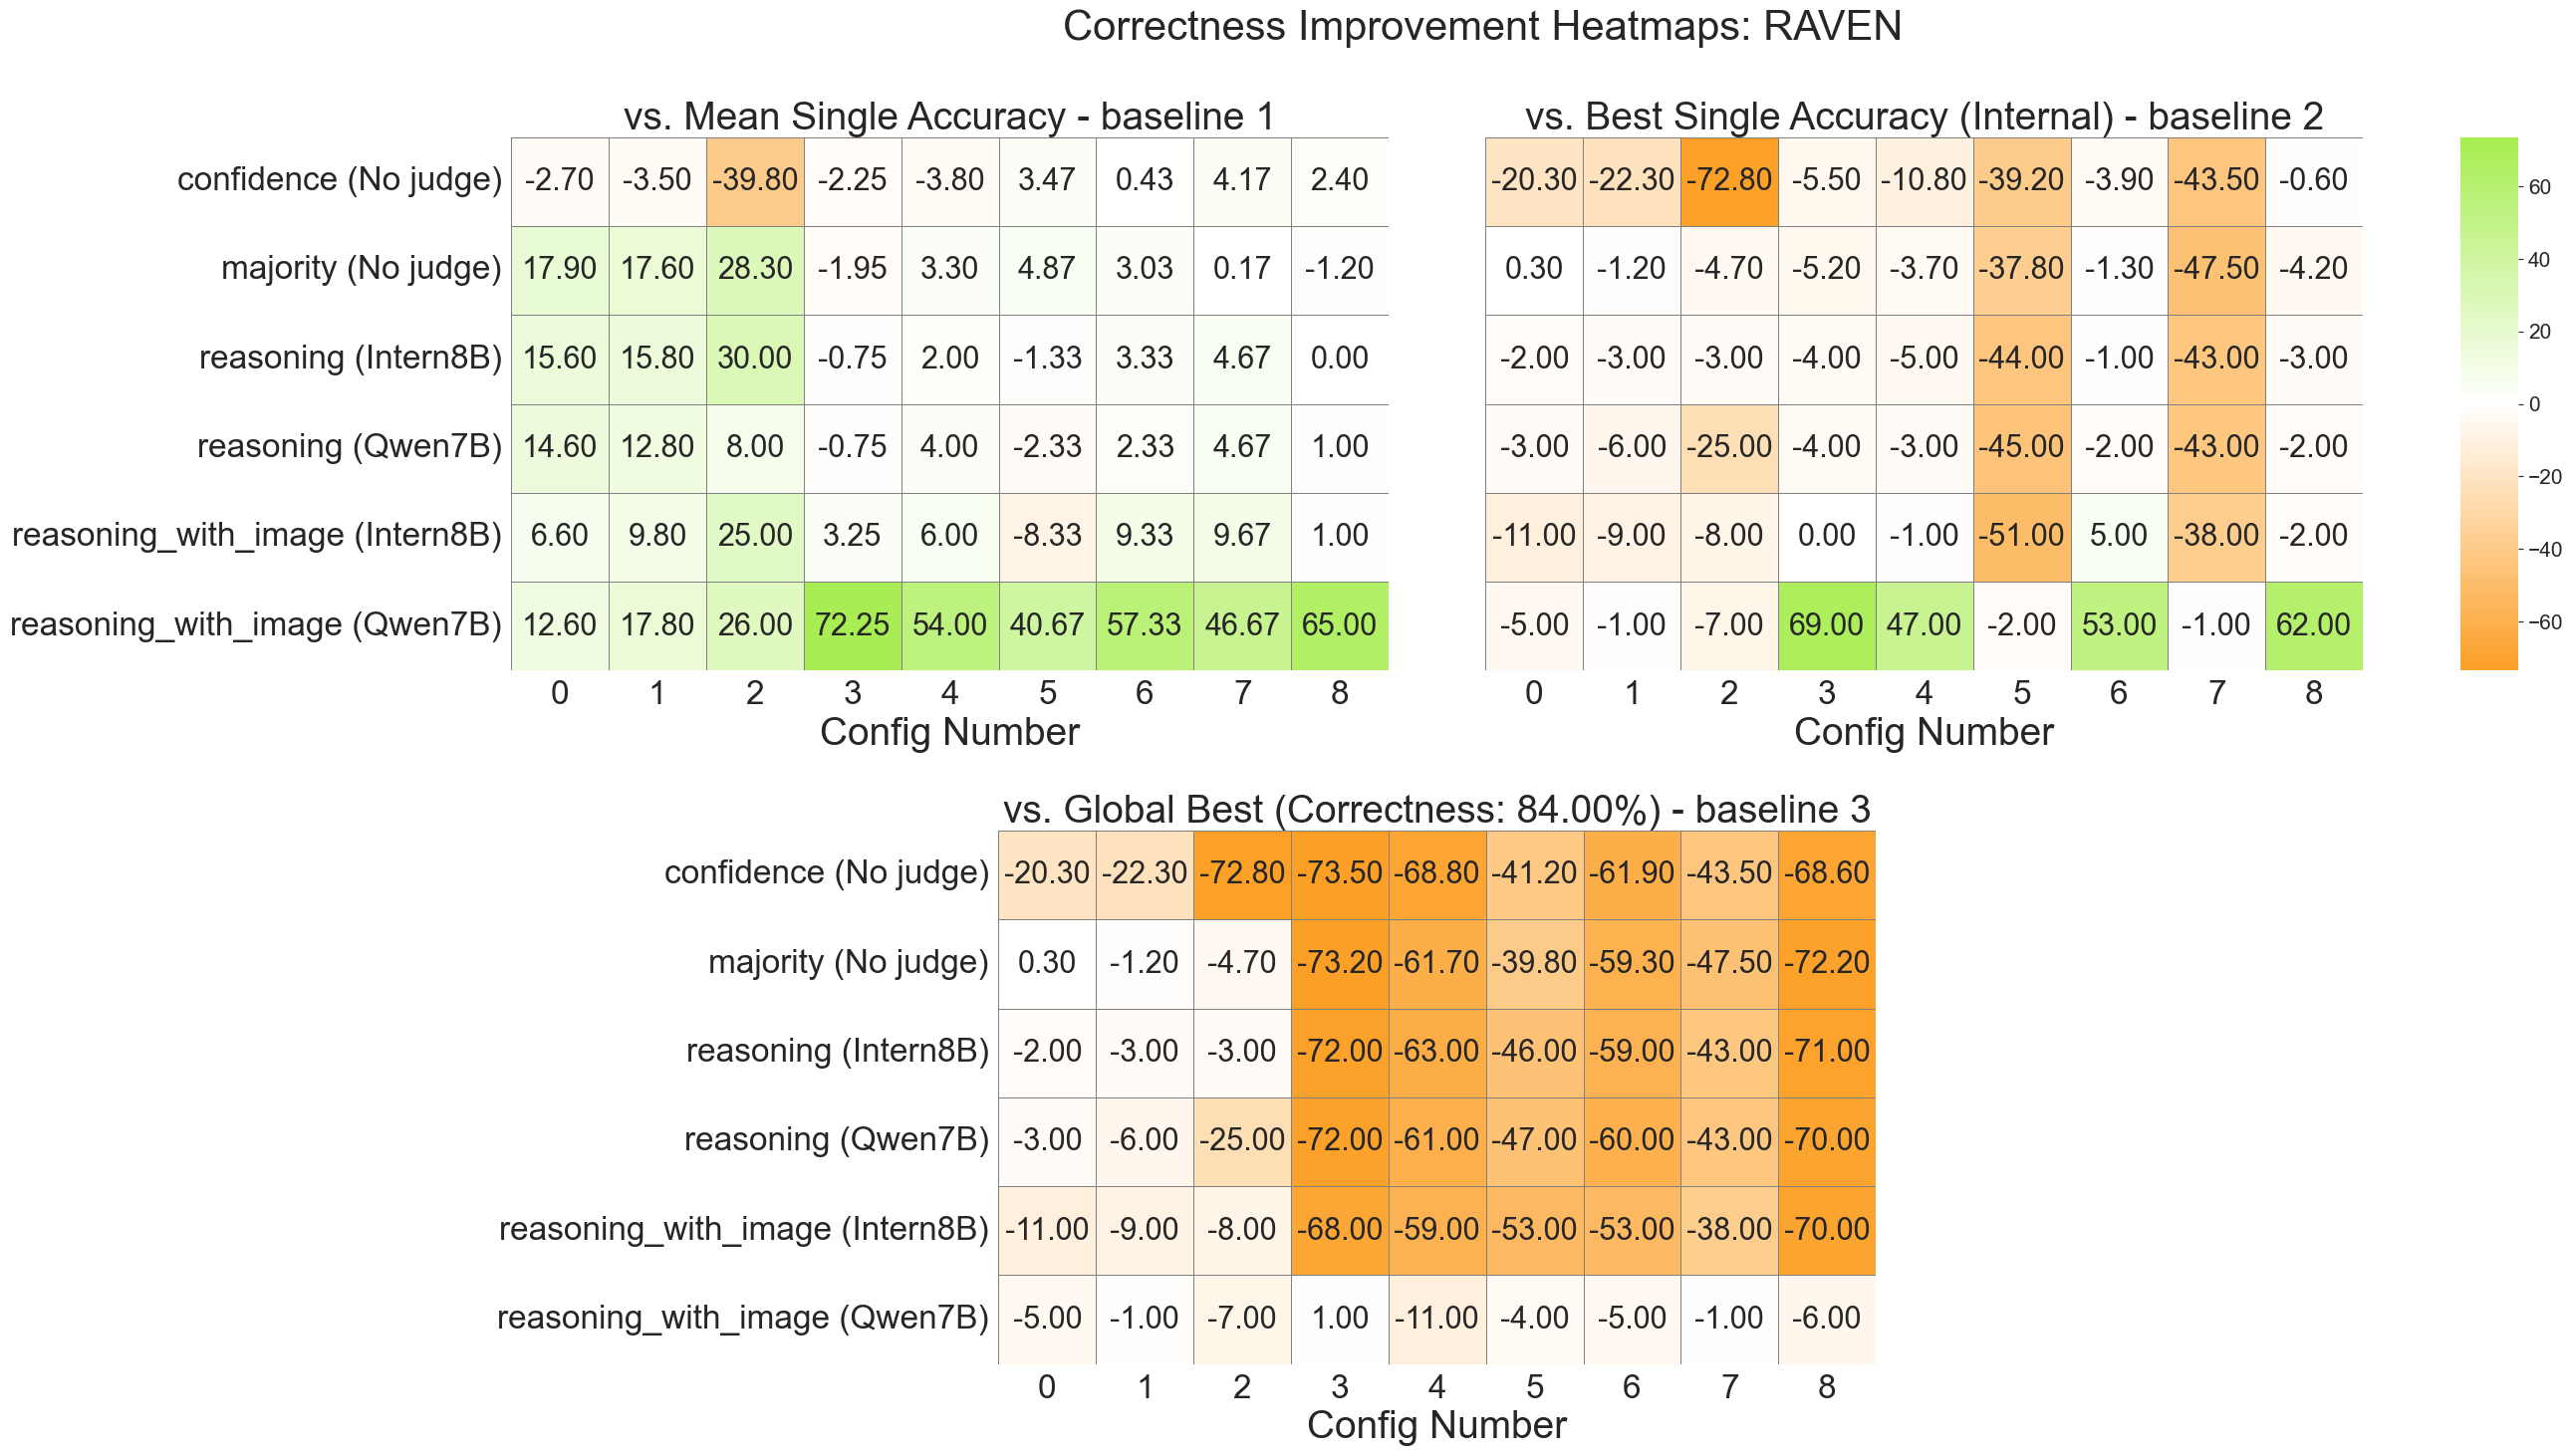

Saved: plots/heatmap_pyramid_bp.png


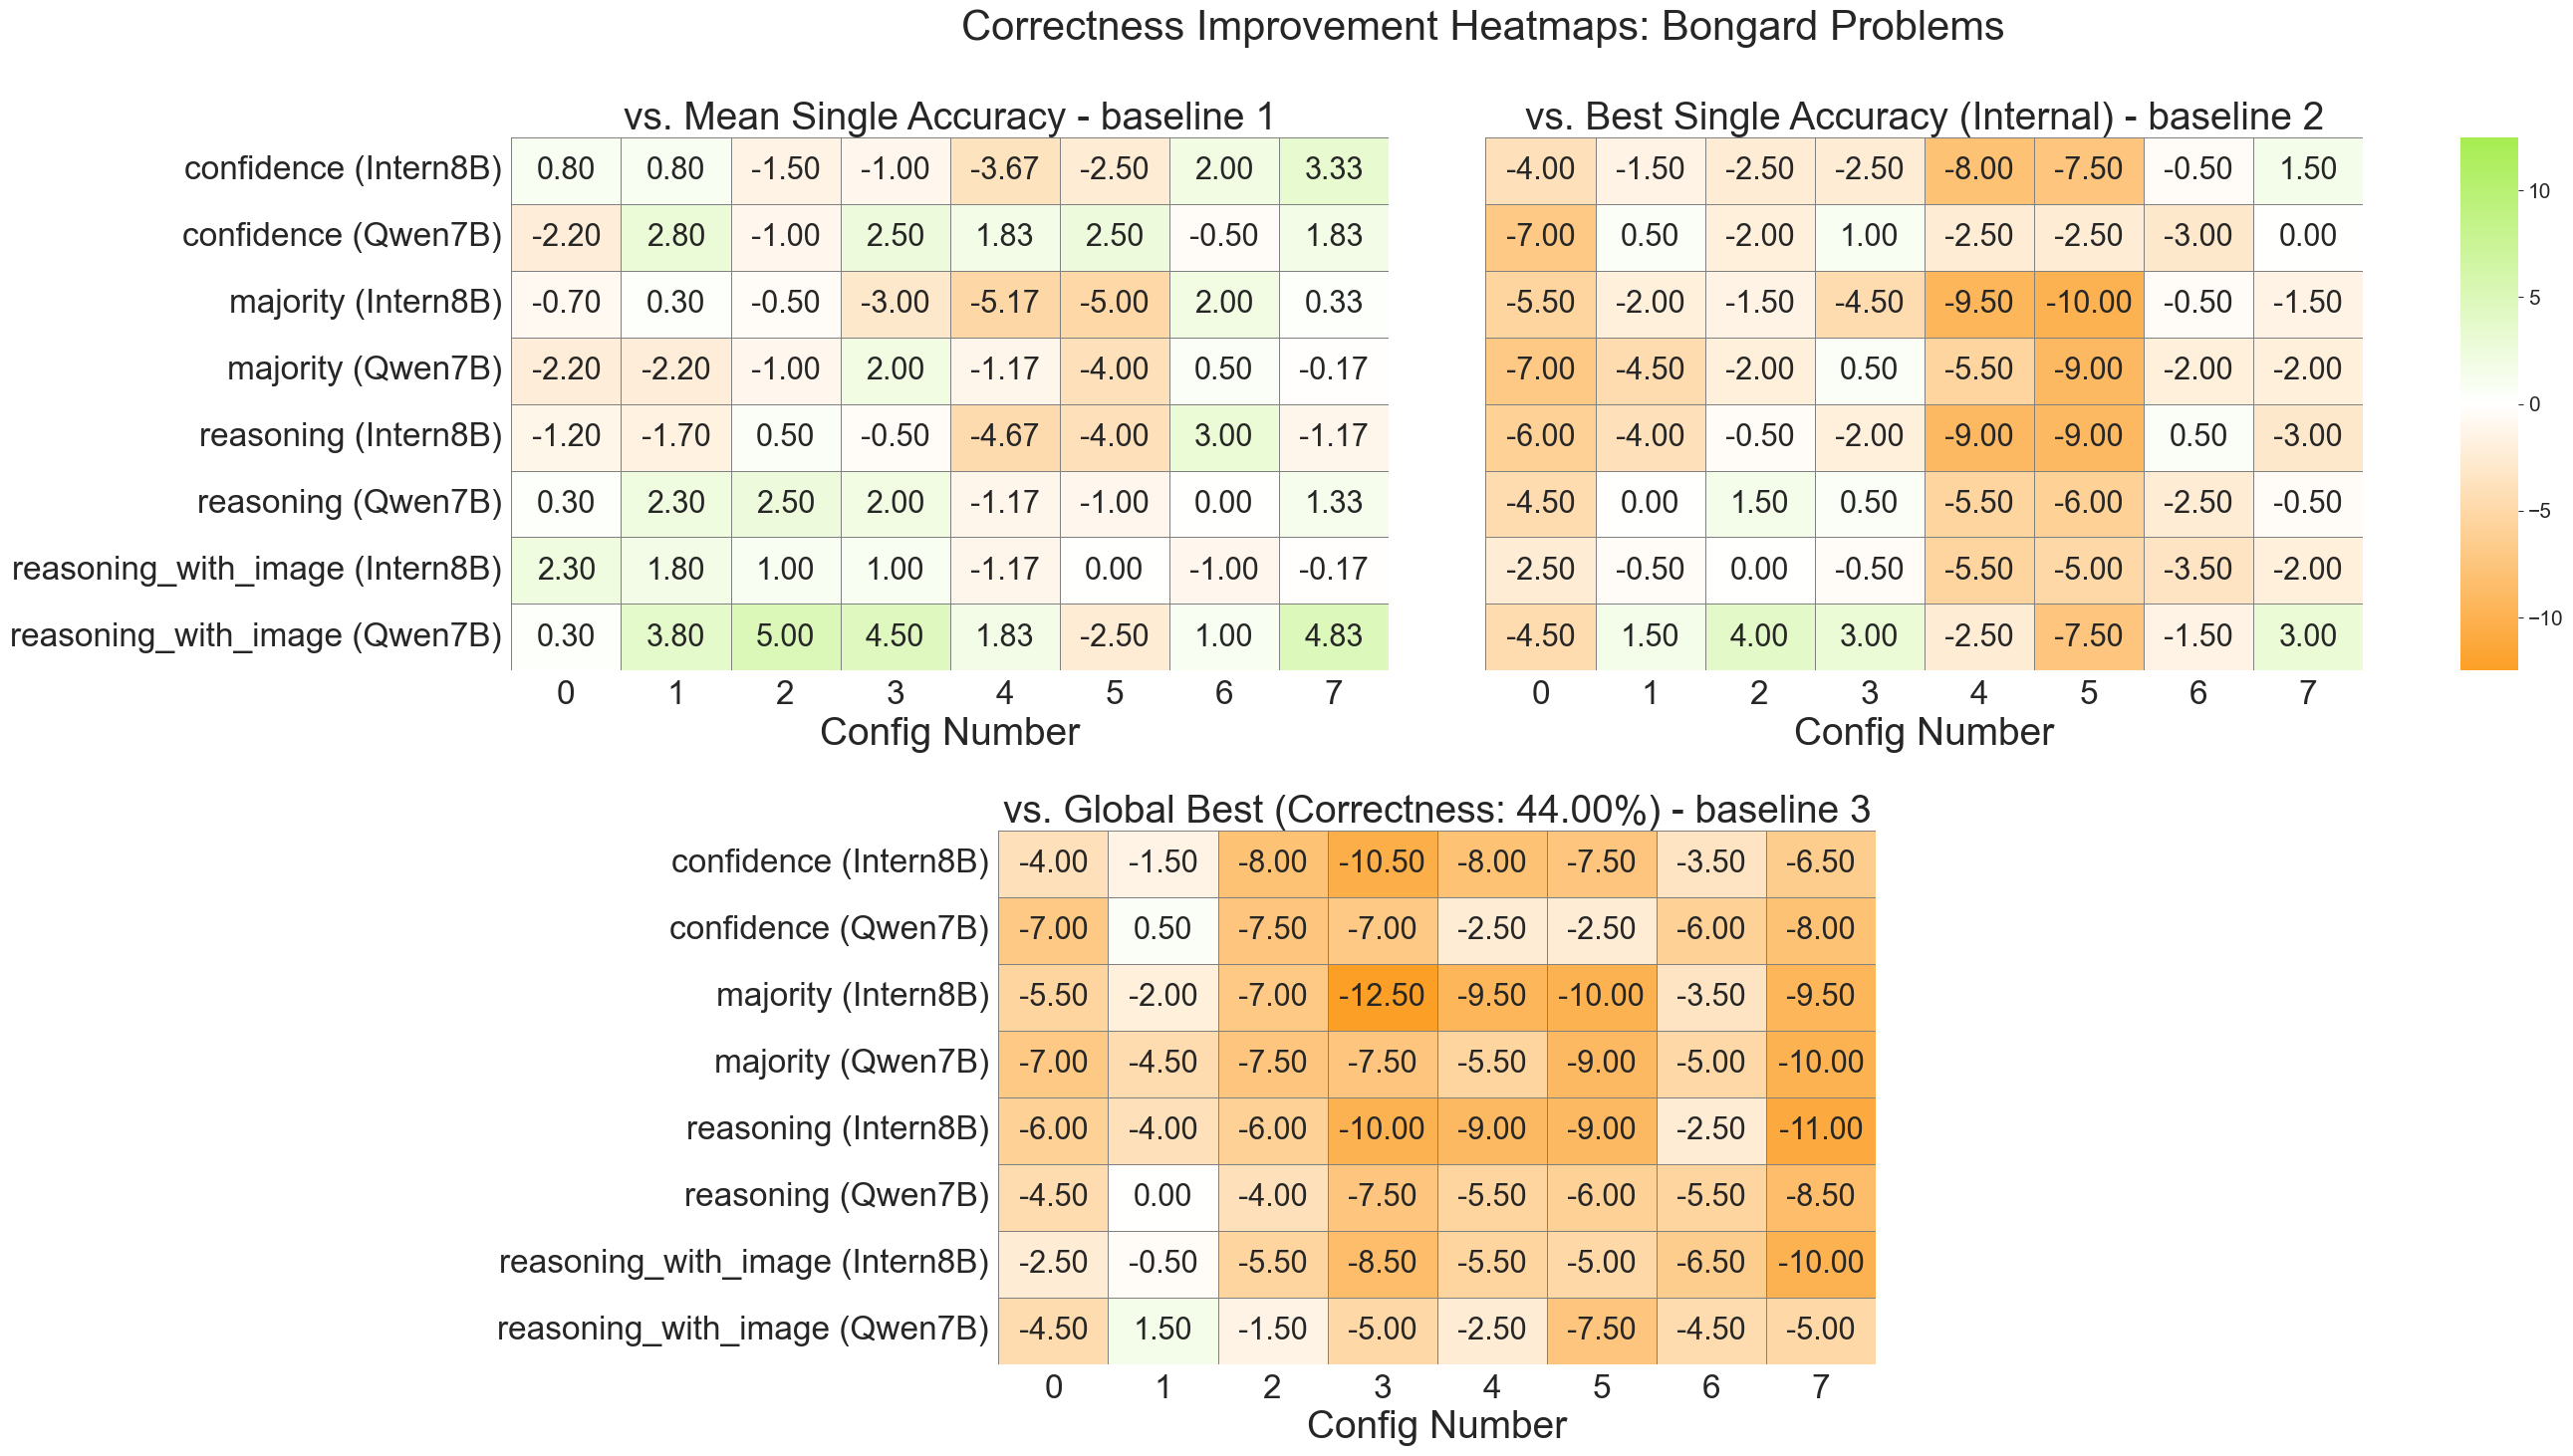

Saved: plots/heatmap_pyramid_cvr.png


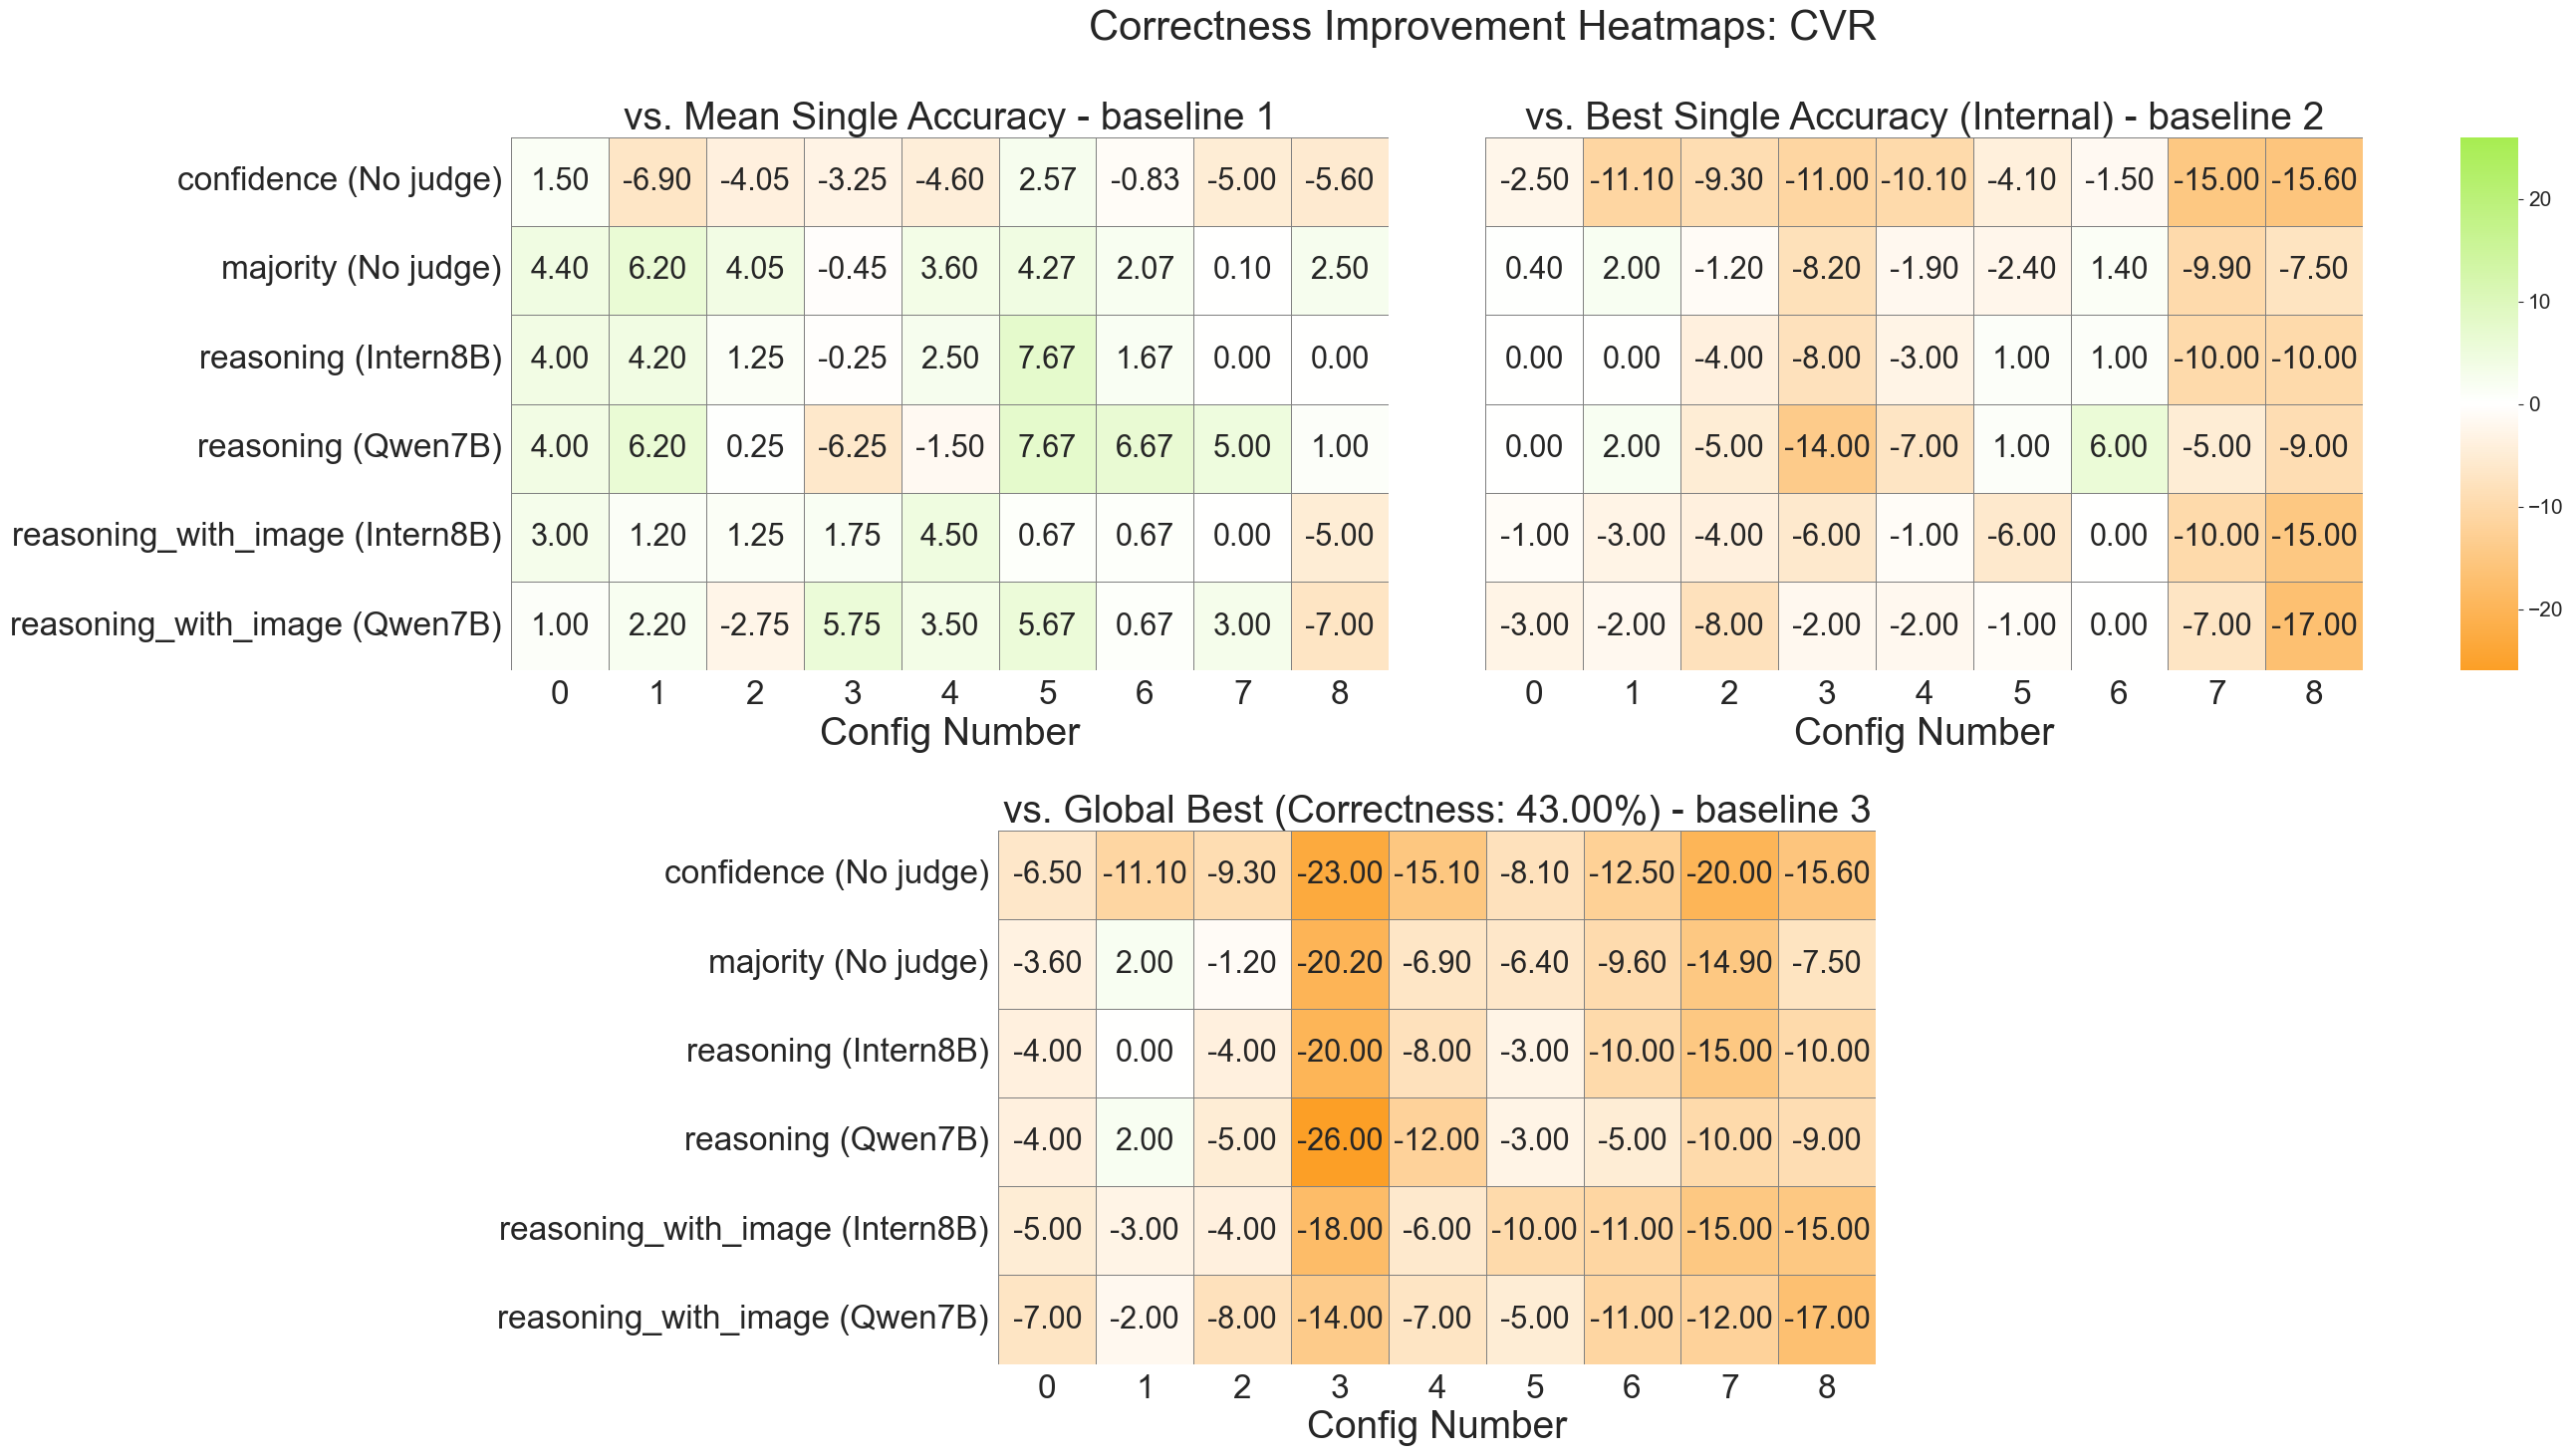

Saved: plots/heatmap_pyramid_marsvqa.png


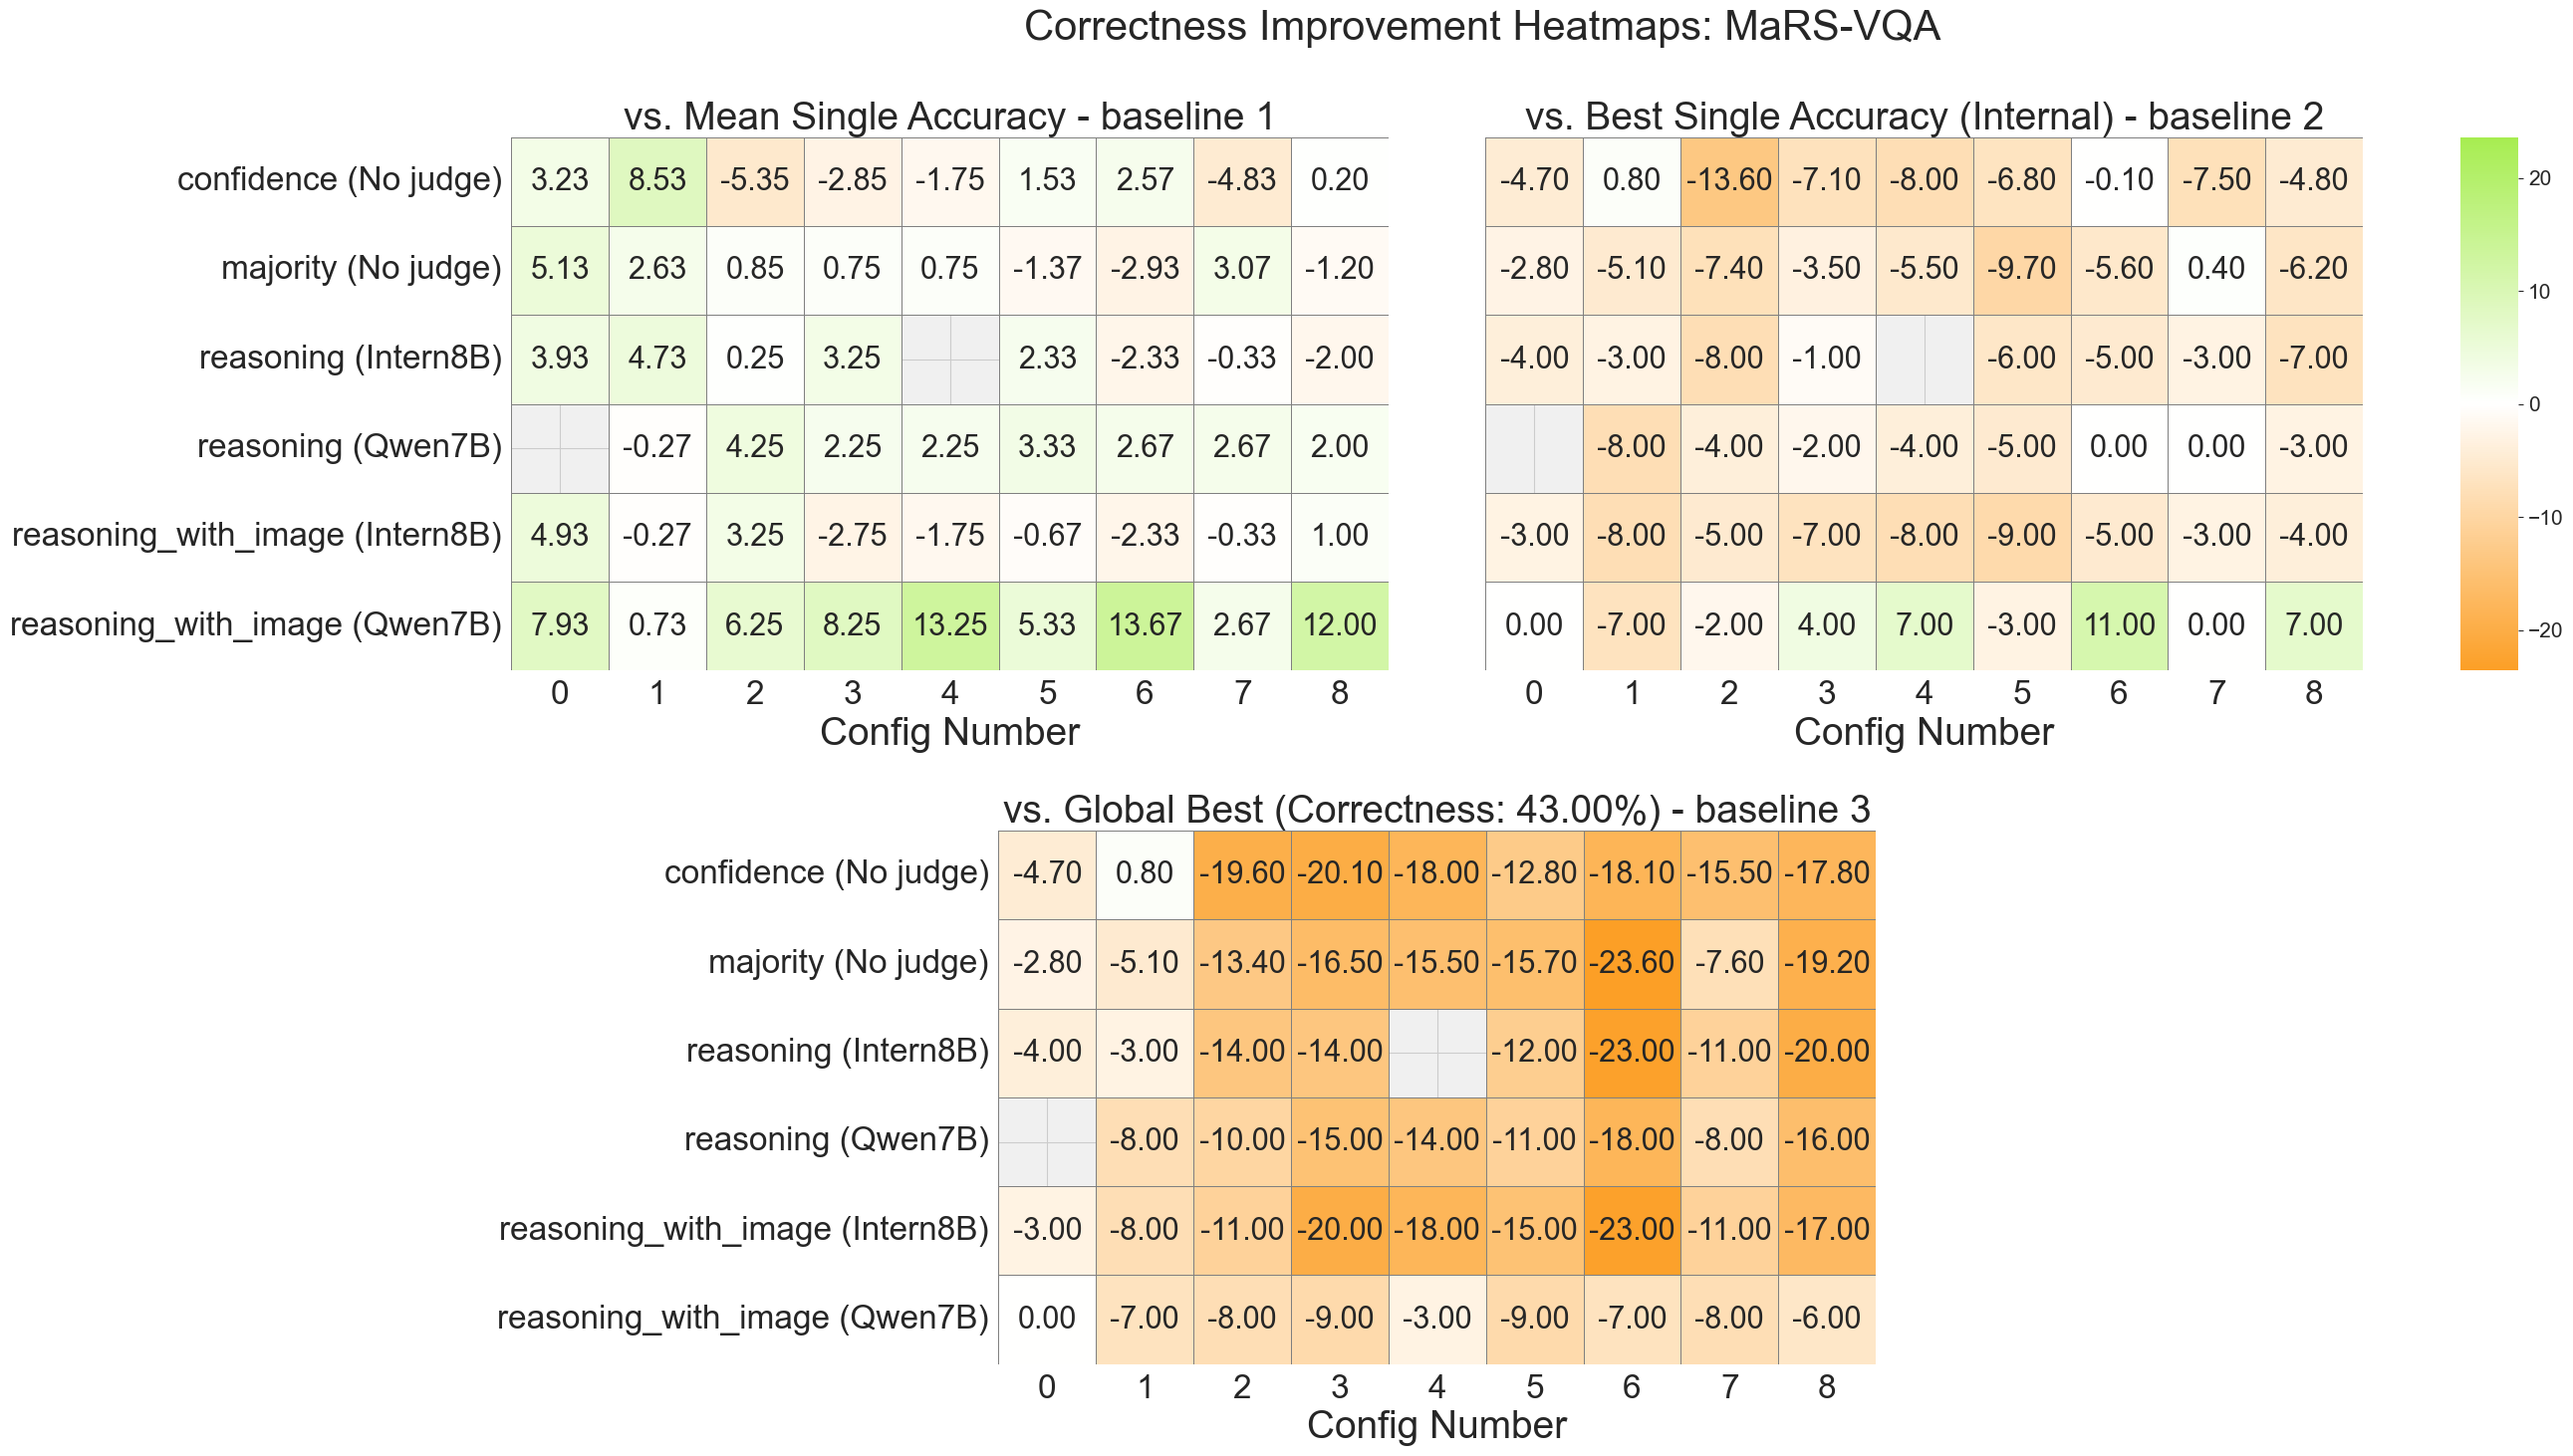

In [278]:
plot_improvement_heatmaps(styled_results)

### html to latex - technical

#### functions and sample data

In [279]:
def transcribe_html_to_latex_underlined(html_content, caption="Model Performance", label="tab:model_perf", transpose=False, round_decimals=None):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # --- 1. Parse CSS Styles ---
    bold_ids = set()
    green_ids = set()
    blue_ids = set() 
    
    style_tag = soup.find('style')
    if style_tag:
        for rule in style_tag.string.split('}'):
            if '{' not in rule: continue
            selectors_str, styles = rule.split('{')
            ids = [s.strip().replace('#', '') for s in selectors_str.split(',')]
            
            if 'font-weight: bold' in styles:
                bold_ids.update(ids)
            if '#a7ed51' in styles:
                green_ids.update(ids)
            if '#48a6fe' in styles: 
                blue_ids.update(ids)

    # --- 2. Build the Data Matrix ---
    matrix = []

    # A. Handle Headers
    thead_rows = soup.select('thead tr')
    if thead_rows:
        data_headers = [th.get_text(strip=True) for th in thead_rows[0].find_all('th')[1:]]
        
        # Handle index name safely
        if len(thead_rows) > 1:
            index_name = thead_rows[1].find_all('th')[0].get_text(strip=True)
        else:
            index_name = "Index"
            
        full_headers = [index_name] + data_headers
        
        formatted_headers = []
        for h in full_headers:
            # 1. Custom Replacement
            h = h.replace("reasoning_with_image", "reasoning w/ image")
            h = h.replace("ens_members_config_number", "Configuration")
            # 2. Escape underscores for LaTeX
            h = h.replace('_', '\\_')
            # 3. Apply Bold (Header default)
            formatted_headers.append(f"\\textbf{{{h}}}")
            
        matrix.append(formatted_headers)

    # B. Handle Body Rows
    tbody_rows = soup.select('tbody tr')
    for tr in tbody_rows:
        cells = tr.find_all(['th', 'td'])
        row_content = []
        for cell in cells:
            cell_id = cell.get('id', '')
            text = cell.get_text(strip=True)
            
            # --- NEW: Round Numerical Values ---
            if round_decimals is not None:
                try:
                    # Attempt to convert to float
                    float_val = float(text)
                    # Format to specific decimal places
                    text = f"{float_val:.{round_decimals}f}"
                except ValueError:
                    # If conversion fails (e.g., text is a string), keep original text
                    pass
            # -----------------------------------
            
            # 1. Apply Background Color
            if cell_id in green_ids:
                text = f"\\cellcolor[HTML]{{A7ED51}}{text}"
            
            # 2. Apply Bold
            if cell_id in bold_ids:
                text = f"\\textbf{{{text}}}"
                
            # 3. Apply Underline (Blue border logic)
            if cell_id in blue_ids:
                text = f"\\underline{{{text}}}"
                
            row_content.append(text)
        matrix.append(row_content)

    # --- 3. Handle Transposition ---
    if transpose:
        matrix = list(map(list, zip(*matrix)))

    # --- 4. Construct LaTeX String ---
    # Calculate columns based on the (potentially transposed) matrix
    num_cols = len(matrix[0]) if matrix else 0
    # Create column definition: first column centered, others centered
    col_def = "|" + "c|" * num_cols
    
    latex_rows = []
    for row in matrix:
        latex_rows.append(" & ".join(row) + " \\\\ \\hline")

    latex_code = f"""
\\begin{{table}}[H]
    \\centering
    \\caption{{{caption}}}
    \\label{{{label}}}
    \\resizebox{{\\textwidth}}{{!}}{{
    \\begin{{tabular}}{{{col_def}}}
    \\hline
"""
    latex_code += "\n    ".join(latex_rows)
    latex_code += """
    \\end{tabular}
    }
\\end{table}
"""
    return latex_code

In [280]:
html_data_raven = """<style type="text/css">
#T_30592_row0_col1, #T_30592_row3_col5 {
  font-weight: bold;
  background-color: #a7ed51;
  border: 3px solid #48a6fe;
}
#T_30592_row0_col2, #T_30592_row0_col3, #T_30592_row0_col4, #T_30592_row0_col5, #T_30592_row1_col1, #T_30592_row1_col2, #T_30592_row1_col3, #T_30592_row1_col4, #T_30592_row1_col5, #T_30592_row2_col1, #T_30592_row2_col2, #T_30592_row2_col3, #T_30592_row2_col4, #T_30592_row2_col5, #T_30592_row3_col4, #T_30592_row4_col1, #T_30592_row4_col2, #T_30592_row4_col3, #T_30592_row4_col4, #T_30592_row5_col0, #T_30592_row5_col1, #T_30592_row5_col5, #T_30592_row6_col0, #T_30592_row6_col1, #T_30592_row6_col2, #T_30592_row6_col3, #T_30592_row7_col0, #T_30592_row7_col1, #T_30592_row7_col2, #T_30592_row7_col3, #T_30592_row7_col4, #T_30592_row7_col5, #T_30592_row8_col0, #T_30592_row8_col3, #T_30592_row8_col4 {
  font-weight: bold;
}
#T_30592_row4_col5, #T_30592_row6_col4, #T_30592_row6_col5, #T_30592_row8_col5 {
  font-weight: bold;
  background-color: #a7ed51;
}
</style>
<table id="T_30592">
  <thead>
    <tr>
      <th class="index_name level0" >column_name</th>
      <th id="T_30592_level0_col0" class="col_heading level0 col0" >confidence (No judge)</th>
      <th id="T_30592_level0_col1" class="col_heading level0 col1" >majority (No judge)</th>
      <th id="T_30592_level0_col2" class="col_heading level0 col2" >reasoning (Intern8B)</th>
      <th id="T_30592_level0_col3" class="col_heading level0 col3" >reasoning (Qwen7B)</th>
      <th id="T_30592_level0_col4" class="col_heading level0 col4" >reasoning_with_image (Intern8B)</th>
      <th id="T_30592_level0_col5" class="col_heading level0 col5" >reasoning_with_image (Qwen7B)</th>
    </tr>
    <tr>
      <th class="index_name level0" >ens_members_config_number</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_30592_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_30592_row0_col0" class="data row0 col0" >0.6370</td>
      <td id="T_30592_row0_col1" class="data row0 col1" >0.8430</td>
      <td id="T_30592_row0_col2" class="data row0 col2" >0.8200</td>
      <td id="T_30592_row0_col3" class="data row0 col3" >0.8100</td>
      <td id="T_30592_row0_col4" class="data row0 col4" >0.7300</td>
      <td id="T_30592_row0_col5" class="data row0 col5" >0.7900</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_30592_row1_col0" class="data row1 col0" >0.6170</td>
      <td id="T_30592_row1_col1" class="data row1 col1" >0.8280</td>
      <td id="T_30592_row1_col2" class="data row1 col2" >0.8100</td>
      <td id="T_30592_row1_col3" class="data row1 col3" >0.7800</td>
      <td id="T_30592_row1_col4" class="data row1 col4" >0.7500</td>
      <td id="T_30592_row1_col5" class="data row1 col5" >0.8300</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_30592_row2_col0" class="data row2 col0" >0.1120</td>
      <td id="T_30592_row2_col1" class="data row2 col1" >0.7930</td>
      <td id="T_30592_row2_col2" class="data row2 col2" >0.8100</td>
      <td id="T_30592_row2_col3" class="data row2 col3" >0.5900</td>
      <td id="T_30592_row2_col4" class="data row2 col4" >0.7600</td>
      <td id="T_30592_row2_col5" class="data row2 col5" >0.7700</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_30592_row3_col0" class="data row3 col0" >0.1050</td>
      <td id="T_30592_row3_col1" class="data row3 col1" >0.1080</td>
      <td id="T_30592_row3_col2" class="data row3 col2" >0.1200</td>
      <td id="T_30592_row3_col3" class="data row3 col3" >0.1200</td>
      <td id="T_30592_row3_col4" class="data row3 col4" >0.1600</td>
      <td id="T_30592_row3_col5" class="data row3 col5" >0.8500</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_30592_row4_col0" class="data row4 col0" >0.1520</td>
      <td id="T_30592_row4_col1" class="data row4 col1" >0.2230</td>
      <td id="T_30592_row4_col2" class="data row4 col2" >0.2100</td>
      <td id="T_30592_row4_col3" class="data row4 col3" >0.2300</td>
      <td id="T_30592_row4_col4" class="data row4 col4" >0.2500</td>
      <td id="T_30592_row4_col5" class="data row4 col5" >0.7300</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row5" class="row_heading level0 row5" >5</th>
      <td id="T_30592_row5_col0" class="data row5 col0" >0.4280</td>
      <td id="T_30592_row5_col1" class="data row5 col1" >0.4420</td>
      <td id="T_30592_row5_col2" class="data row5 col2" >0.3800</td>
      <td id="T_30592_row5_col3" class="data row5 col3" >0.3700</td>
      <td id="T_30592_row5_col4" class="data row5 col4" >0.3100</td>
      <td id="T_30592_row5_col5" class="data row5 col5" >0.8000</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row6" class="row_heading level0 row6" >6</th>
      <td id="T_30592_row6_col0" class="data row6 col0" >0.2210</td>
      <td id="T_30592_row6_col1" class="data row6 col1" >0.2470</td>
      <td id="T_30592_row6_col2" class="data row6 col2" >0.2500</td>
      <td id="T_30592_row6_col3" class="data row6 col3" >0.2400</td>
      <td id="T_30592_row6_col4" class="data row6 col4" >0.3100</td>
      <td id="T_30592_row6_col5" class="data row6 col5" >0.7900</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row7" class="row_heading level0 row7" >7</th>
      <td id="T_30592_row7_col0" class="data row7 col0" >0.4050</td>
      <td id="T_30592_row7_col1" class="data row7 col1" >0.3650</td>
      <td id="T_30592_row7_col2" class="data row7 col2" >0.4100</td>
      <td id="T_30592_row7_col3" class="data row7 col3" >0.4100</td>
      <td id="T_30592_row7_col4" class="data row7 col4" >0.4600</td>
      <td id="T_30592_row7_col5" class="data row7 col5" >0.8300</td>
    </tr>
    <tr>
      <th id="T_30592_level0_row8" class="row_heading level0 row8" >8</th>
      <td id="T_30592_row8_col0" class="data row8 col0" >0.1540</td>
      <td id="T_30592_row8_col1" class="data row8 col1" >0.1180</td>
      <td id="T_30592_row8_col2" class="data row8 col2" >0.1300</td>
      <td id="T_30592_row8_col3" class="data row8 col3" >0.1400</td>
      <td id="T_30592_row8_col4" class="data row8 col4" >0.1400</td>
      <td id="T_30592_row8_col5" class="data row8 col5" >0.7800</td>
    </tr>
  </tbody>
</table>
"""

html_data_bp = """
<style type="text/css">
#T_ffb14_row0_col0, #T_ffb14_row0_col5, #T_ffb14_row0_col6, #T_ffb14_row0_col7, #T_ffb14_row1_col0, #T_ffb14_row1_col2, #T_ffb14_row1_col5, #T_ffb14_row1_col6, #T_ffb14_row2_col4, #T_ffb14_row2_col6, #T_ffb14_row3_col6, #T_ffb14_row4_col1, #T_ffb14_row4_col7, #T_ffb14_row5_col1, #T_ffb14_row6_col0, #T_ffb14_row6_col2, #T_ffb14_row6_col3, #T_ffb14_row6_col7, #T_ffb14_row7_col1, #T_ffb14_row7_col2, #T_ffb14_row7_col5 {
  font-weight: bold;
}
#T_ffb14_row1_col1, #T_ffb14_row1_col7 {
  font-weight: bold;
  background-color: #a7ed51;
  border: 3px solid #48a6fe;
}
#T_ffb14_row2_col5, #T_ffb14_row2_col7, #T_ffb14_row3_col1, #T_ffb14_row3_col3, #T_ffb14_row3_col5, #T_ffb14_row3_col7, #T_ffb14_row6_col4, #T_ffb14_row7_col0, #T_ffb14_row7_col7 {
  font-weight: bold;
  background-color: #a7ed51;
}
</style>
<table id="T_ffb14">
  <thead>
    <tr>
      <th class="index_name level0" >column_name</th>
      <th id="T_ffb14_level0_col0" class="col_heading level0 col0" >confidence (Intern8B)</th>
      <th id="T_ffb14_level0_col1" class="col_heading level0 col1" >confidence (Qwen7B)</th>
      <th id="T_ffb14_level0_col2" class="col_heading level0 col2" >majority (Intern8B)</th>
      <th id="T_ffb14_level0_col3" class="col_heading level0 col3" >majority (Qwen7B)</th>
      <th id="T_ffb14_level0_col4" class="col_heading level0 col4" >reasoning (Intern8B)</th>
      <th id="T_ffb14_level0_col5" class="col_heading level0 col5" >reasoning (Qwen7B)</th>
      <th id="T_ffb14_level0_col6" class="col_heading level0 col6" >reasoning_with_image (Intern8B)</th>
      <th id="T_ffb14_level0_col7" class="col_heading level0 col7" >reasoning_with_image (Qwen7B)</th>
    </tr>
    <tr>
      <th class="index_name level0" >ens_members_config_number</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_ffb14_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_ffb14_row0_col0" class="data row0 col0" >0.4000</td>
      <td id="T_ffb14_row0_col1" class="data row0 col1" >0.3700</td>
      <td id="T_ffb14_row0_col2" class="data row0 col2" >0.3850</td>
      <td id="T_ffb14_row0_col3" class="data row0 col3" >0.3700</td>
      <td id="T_ffb14_row0_col4" class="data row0 col4" >0.3800</td>
      <td id="T_ffb14_row0_col5" class="data row0 col5" >0.3950</td>
      <td id="T_ffb14_row0_col6" class="data row0 col6" >0.4150</td>
      <td id="T_ffb14_row0_col7" class="data row0 col7" >0.3950</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_ffb14_row1_col0" class="data row1 col0" >0.4250</td>
      <td id="T_ffb14_row1_col1" class="data row1 col1" >0.4450</td>
      <td id="T_ffb14_row1_col2" class="data row1 col2" >0.4200</td>
      <td id="T_ffb14_row1_col3" class="data row1 col3" >0.3950</td>
      <td id="T_ffb14_row1_col4" class="data row1 col4" >0.4000</td>
      <td id="T_ffb14_row1_col5" class="data row1 col5" >0.4400</td>
      <td id="T_ffb14_row1_col6" class="data row1 col6" >0.4350</td>
      <td id="T_ffb14_row1_col7" class="data row1 col7" >0.4550</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_ffb14_row2_col0" class="data row2 col0" >0.3600</td>
      <td id="T_ffb14_row2_col1" class="data row2 col1" >0.3650</td>
      <td id="T_ffb14_row2_col2" class="data row2 col2" >0.3700</td>
      <td id="T_ffb14_row2_col3" class="data row2 col3" >0.3650</td>
      <td id="T_ffb14_row2_col4" class="data row2 col4" >0.3800</td>
      <td id="T_ffb14_row2_col5" class="data row2 col5" >0.4000</td>
      <td id="T_ffb14_row2_col6" class="data row2 col6" >0.3850</td>
      <td id="T_ffb14_row2_col7" class="data row2 col7" >0.4250</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_ffb14_row3_col0" class="data row3 col0" >0.3350</td>
      <td id="T_ffb14_row3_col1" class="data row3 col1" >0.3700</td>
      <td id="T_ffb14_row3_col2" class="data row3 col2" >0.3150</td>
      <td id="T_ffb14_row3_col3" class="data row3 col3" >0.3650</td>
      <td id="T_ffb14_row3_col4" class="data row3 col4" >0.3400</td>
      <td id="T_ffb14_row3_col5" class="data row3 col5" >0.3650</td>
      <td id="T_ffb14_row3_col6" class="data row3 col6" >0.3550</td>
      <td id="T_ffb14_row3_col7" class="data row3 col7" >0.3900</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_ffb14_row4_col0" class="data row4 col0" >0.3600</td>
      <td id="T_ffb14_row4_col1" class="data row4 col1" >0.4150</td>
      <td id="T_ffb14_row4_col2" class="data row4 col2" >0.3450</td>
      <td id="T_ffb14_row4_col3" class="data row4 col3" >0.3850</td>
      <td id="T_ffb14_row4_col4" class="data row4 col4" >0.3500</td>
      <td id="T_ffb14_row4_col5" class="data row4 col5" >0.3850</td>
      <td id="T_ffb14_row4_col6" class="data row4 col6" >0.3850</td>
      <td id="T_ffb14_row4_col7" class="data row4 col7" >0.4150</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row5" class="row_heading level0 row5" >5</th>
      <td id="T_ffb14_row5_col0" class="data row5 col0" >0.3650</td>
      <td id="T_ffb14_row5_col1" class="data row5 col1" >0.4150</td>
      <td id="T_ffb14_row5_col2" class="data row5 col2" >0.3400</td>
      <td id="T_ffb14_row5_col3" class="data row5 col3" >0.3500</td>
      <td id="T_ffb14_row5_col4" class="data row5 col4" >0.3500</td>
      <td id="T_ffb14_row5_col5" class="data row5 col5" >0.3800</td>
      <td id="T_ffb14_row5_col6" class="data row5 col6" >0.3900</td>
      <td id="T_ffb14_row5_col7" class="data row5 col7" >0.3650</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row6" class="row_heading level0 row6" >6</th>
      <td id="T_ffb14_row6_col0" class="data row6 col0" >0.4050</td>
      <td id="T_ffb14_row6_col1" class="data row6 col1" >0.3800</td>
      <td id="T_ffb14_row6_col2" class="data row6 col2" >0.4050</td>
      <td id="T_ffb14_row6_col3" class="data row6 col3" >0.3900</td>
      <td id="T_ffb14_row6_col4" class="data row6 col4" >0.4150</td>
      <td id="T_ffb14_row6_col5" class="data row6 col5" >0.3850</td>
      <td id="T_ffb14_row6_col6" class="data row6 col6" >0.3750</td>
      <td id="T_ffb14_row6_col7" class="data row6 col7" >0.3950</td>
    </tr>
    <tr>
      <th id="T_ffb14_level0_row7" class="row_heading level0 row7" >7</th>
      <td id="T_ffb14_row7_col0" class="data row7 col0" >0.3750</td>
      <td id="T_ffb14_row7_col1" class="data row7 col1" >0.3600</td>
      <td id="T_ffb14_row7_col2" class="data row7 col2" >0.3450</td>
      <td id="T_ffb14_row7_col3" class="data row7 col3" >0.3400</td>
      <td id="T_ffb14_row7_col4" class="data row7 col4" >0.3300</td>
      <td id="T_ffb14_row7_col5" class="data row7 col5" >0.3550</td>
      <td id="T_ffb14_row7_col6" class="data row7 col6" >0.3400</td>
      <td id="T_ffb14_row7_col7" class="data row7 col7" >0.3900</td>
    </tr>
  </tbody>
</table>
"""

html_data_cvr = """"
<style type="text/css">
#T_a56e8_row0_col0, #T_a56e8_row0_col2, #T_a56e8_row0_col3, #T_a56e8_row0_col4, #T_a56e8_row0_col5, #T_a56e8_row1_col2, #T_a56e8_row1_col4, #T_a56e8_row1_col5, #T_a56e8_row2_col1, #T_a56e8_row2_col2, #T_a56e8_row2_col3, #T_a56e8_row2_col4, #T_a56e8_row3_col4, #T_a56e8_row3_col5, #T_a56e8_row4_col1, #T_a56e8_row4_col2, #T_a56e8_row4_col4, #T_a56e8_row4_col5, #T_a56e8_row5_col0, #T_a56e8_row5_col1, #T_a56e8_row5_col4, #T_a56e8_row5_col5, #T_a56e8_row6_col4, #T_a56e8_row6_col5, #T_a56e8_row7_col1, #T_a56e8_row7_col3, #T_a56e8_row7_col5, #T_a56e8_row8_col1, #T_a56e8_row8_col3 {
  font-weight: bold;
}
#T_a56e8_row0_col1, #T_a56e8_row5_col2, #T_a56e8_row5_col3, #T_a56e8_row6_col1, #T_a56e8_row6_col2, #T_a56e8_row6_col3 {
  font-weight: bold;
  background-color: #a7ed51;
}
#T_a56e8_row1_col1, #T_a56e8_row1_col3 {
  font-weight: bold;
  background-color: #a7ed51;
  border: 3px solid #48a6fe;
}
</style>
<table id="T_a56e8">
  <thead>
    <tr>
      <th class="index_name level0" >column_name</th>
      <th id="T_a56e8_level0_col0" class="col_heading level0 col0" >confidence (No judge)</th>
      <th id="T_a56e8_level0_col1" class="col_heading level0 col1" >majority (No judge)</th>
      <th id="T_a56e8_level0_col2" class="col_heading level0 col2" >reasoning (Intern8B)</th>
      <th id="T_a56e8_level0_col3" class="col_heading level0 col3" >reasoning (Qwen7B)</th>
      <th id="T_a56e8_level0_col4" class="col_heading level0 col4" >reasoning_with_image (Intern8B)</th>
      <th id="T_a56e8_level0_col5" class="col_heading level0 col5" >reasoning_with_image (Qwen7B)</th>
    </tr>
    <tr>
      <th class="index_name level0" >ens_members_config_number</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_a56e8_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_a56e8_row0_col0" class="data row0 col0" >0.3650</td>
      <td id="T_a56e8_row0_col1" class="data row0 col1" >0.3940</td>
      <td id="T_a56e8_row0_col2" class="data row0 col2" >0.3900</td>
      <td id="T_a56e8_row0_col3" class="data row0 col3" >0.3900</td>
      <td id="T_a56e8_row0_col4" class="data row0 col4" >0.3800</td>
      <td id="T_a56e8_row0_col5" class="data row0 col5" >0.3600</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_a56e8_row1_col0" class="data row1 col0" >0.3190</td>
      <td id="T_a56e8_row1_col1" class="data row1 col1" >0.4500</td>
      <td id="T_a56e8_row1_col2" class="data row1 col2" >0.4300</td>
      <td id="T_a56e8_row1_col3" class="data row1 col3" >0.4500</td>
      <td id="T_a56e8_row1_col4" class="data row1 col4" >0.4000</td>
      <td id="T_a56e8_row1_col5" class="data row1 col5" >0.4100</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_a56e8_row2_col0" class="data row2 col0" >0.3370</td>
      <td id="T_a56e8_row2_col1" class="data row2 col1" >0.4180</td>
      <td id="T_a56e8_row2_col2" class="data row2 col2" >0.3900</td>
      <td id="T_a56e8_row2_col3" class="data row2 col3" >0.3800</td>
      <td id="T_a56e8_row2_col4" class="data row2 col4" >0.3900</td>
      <td id="T_a56e8_row2_col5" class="data row2 col5" >0.3500</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_a56e8_row3_col0" class="data row3 col0" >0.2000</td>
      <td id="T_a56e8_row3_col1" class="data row3 col1" >0.2280</td>
      <td id="T_a56e8_row3_col2" class="data row3 col2" >0.2300</td>
      <td id="T_a56e8_row3_col3" class="data row3 col3" >0.1700</td>
      <td id="T_a56e8_row3_col4" class="data row3 col4" >0.2500</td>
      <td id="T_a56e8_row3_col5" class="data row3 col5" >0.2900</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_a56e8_row4_col0" class="data row4 col0" >0.2790</td>
      <td id="T_a56e8_row4_col1" class="data row4 col1" >0.3610</td>
      <td id="T_a56e8_row4_col2" class="data row4 col2" >0.3500</td>
      <td id="T_a56e8_row4_col3" class="data row4 col3" >0.3100</td>
      <td id="T_a56e8_row4_col4" class="data row4 col4" >0.3700</td>
      <td id="T_a56e8_row4_col5" class="data row4 col5" >0.3600</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row5" class="row_heading level0 row5" >5</th>
      <td id="T_a56e8_row5_col0" class="data row5 col0" >0.3490</td>
      <td id="T_a56e8_row5_col1" class="data row5 col1" >0.3660</td>
      <td id="T_a56e8_row5_col2" class="data row5 col2" >0.4000</td>
      <td id="T_a56e8_row5_col3" class="data row5 col3" >0.4000</td>
      <td id="T_a56e8_row5_col4" class="data row5 col4" >0.3300</td>
      <td id="T_a56e8_row5_col5" class="data row5 col5" >0.3800</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row6" class="row_heading level0 row6" >6</th>
      <td id="T_a56e8_row6_col0" class="data row6 col0" >0.3050</td>
      <td id="T_a56e8_row6_col1" class="data row6 col1" >0.3340</td>
      <td id="T_a56e8_row6_col2" class="data row6 col2" >0.3300</td>
      <td id="T_a56e8_row6_col3" class="data row6 col3" >0.3800</td>
      <td id="T_a56e8_row6_col4" class="data row6 col4" >0.3200</td>
      <td id="T_a56e8_row6_col5" class="data row6 col5" >0.3200</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row7" class="row_heading level0 row7" >7</th>
      <td id="T_a56e8_row7_col0" class="data row7 col0" >0.2300</td>
      <td id="T_a56e8_row7_col1" class="data row7 col1" >0.2810</td>
      <td id="T_a56e8_row7_col2" class="data row7 col2" >0.2800</td>
      <td id="T_a56e8_row7_col3" class="data row7 col3" >0.3300</td>
      <td id="T_a56e8_row7_col4" class="data row7 col4" >0.2800</td>
      <td id="T_a56e8_row7_col5" class="data row7 col5" >0.3100</td>
    </tr>
    <tr>
      <th id="T_a56e8_level0_row8" class="row_heading level0 row8" >8</th>
      <td id="T_a56e8_row8_col0" class="data row8 col0" >0.2740</td>
      <td id="T_a56e8_row8_col1" class="data row8 col1" >0.3550</td>
      <td id="T_a56e8_row8_col2" class="data row8 col2" >0.3300</td>
      <td id="T_a56e8_row8_col3" class="data row8 col3" >0.3400</td>
      <td id="T_a56e8_row8_col4" class="data row8 col4" >0.2800</td>
      <td id="T_a56e8_row8_col5" class="data row8 col5" >0.2600</td>
    </tr>
  </tbody>
</table>
"""

html_data_mars = """<style type="text/css">
#T_dcf2f_row0_col0, #T_dcf2f_row0_col1, #T_dcf2f_row0_col2, #T_dcf2f_row0_col4, #T_dcf2f_row0_col5, #T_dcf2f_row1_col1, #T_dcf2f_row1_col2, #T_dcf2f_row1_col5, #T_dcf2f_row2_col1, #T_dcf2f_row2_col2, #T_dcf2f_row2_col3, #T_dcf2f_row2_col4, #T_dcf2f_row2_col5, #T_dcf2f_row3_col1, #T_dcf2f_row3_col2, #T_dcf2f_row3_col3, #T_dcf2f_row4_col1, #T_dcf2f_row4_col3, #T_dcf2f_row5_col0, #T_dcf2f_row5_col2, #T_dcf2f_row5_col3, #T_dcf2f_row5_col5, #T_dcf2f_row6_col0, #T_dcf2f_row6_col3, #T_dcf2f_row7_col3, #T_dcf2f_row7_col5, #T_dcf2f_row8_col0, #T_dcf2f_row8_col3, #T_dcf2f_row8_col4 {
  font-weight: bold;
}
#T_dcf2f_row1_col0, #T_dcf2f_row3_col5, #T_dcf2f_row4_col5, #T_dcf2f_row6_col5, #T_dcf2f_row7_col1, #T_dcf2f_row8_col5 {
  font-weight: bold;
  background-color: #a7ed51;
}
</style>
<table id="T_dcf2f">
  <thead>
    <tr>
      <th class="index_name level0" >column_name</th>
      <th id="T_dcf2f_level0_col0" class="col_heading level0 col0" >confidence (No judge)</th>
      <th id="T_dcf2f_level0_col1" class="col_heading level0 col1" >majority (No judge)</th>
      <th id="T_dcf2f_level0_col2" class="col_heading level0 col2" >reasoning (Intern8B)</th>
      <th id="T_dcf2f_level0_col3" class="col_heading level0 col3" >reasoning (Qwen7B)</th>
      <th id="T_dcf2f_level0_col4" class="col_heading level0 col4" >reasoning_with_image (Intern8B)</th>
      <th id="T_dcf2f_level0_col5" class="col_heading level0 col5" >reasoning_with_image (Qwen7B)</th>
    </tr>
    <tr>
      <th class="index_name level0" >ens_members_config_number</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_dcf2f_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_dcf2f_row0_col0" class="data row0 col0" >0.3830</td>
      <td id="T_dcf2f_row0_col1" class="data row0 col1" >0.4020</td>
      <td id="T_dcf2f_row0_col2" class="data row0 col2" >0.3900</td>
      <td id="T_dcf2f_row0_col3" class="data row0 col3" >nan</td>
      <td id="T_dcf2f_row0_col4" class="data row0 col4" >0.4000</td>
      <td id="T_dcf2f_row0_col5" class="data row0 col5" >0.4300</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_dcf2f_row1_col0" class="data row1 col0" >0.4380</td>
      <td id="T_dcf2f_row1_col1" class="data row1 col1" >0.3790</td>
      <td id="T_dcf2f_row1_col2" class="data row1 col2" >0.4000</td>
      <td id="T_dcf2f_row1_col3" class="data row1 col3" >0.3500</td>
      <td id="T_dcf2f_row1_col4" class="data row1 col4" >0.3500</td>
      <td id="T_dcf2f_row1_col5" class="data row1 col5" >0.3600</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_dcf2f_row2_col0" class="data row2 col0" >0.2340</td>
      <td id="T_dcf2f_row2_col1" class="data row2 col1" >0.2960</td>
      <td id="T_dcf2f_row2_col2" class="data row2 col2" >0.2900</td>
      <td id="T_dcf2f_row2_col3" class="data row2 col3" >0.3300</td>
      <td id="T_dcf2f_row2_col4" class="data row2 col4" >0.3200</td>
      <td id="T_dcf2f_row2_col5" class="data row2 col5" >0.3500</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_dcf2f_row3_col0" class="data row3 col0" >0.2290</td>
      <td id="T_dcf2f_row3_col1" class="data row3 col1" >0.2650</td>
      <td id="T_dcf2f_row3_col2" class="data row3 col2" >0.2900</td>
      <td id="T_dcf2f_row3_col3" class="data row3 col3" >0.2800</td>
      <td id="T_dcf2f_row3_col4" class="data row3 col4" >0.2300</td>
      <td id="T_dcf2f_row3_col5" class="data row3 col5" >0.3400</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_dcf2f_row4_col0" class="data row4 col0" >0.2500</td>
      <td id="T_dcf2f_row4_col1" class="data row4 col1" >0.2750</td>
      <td id="T_dcf2f_row4_col2" class="data row4 col2" >nan</td>
      <td id="T_dcf2f_row4_col3" class="data row4 col3" >0.2900</td>
      <td id="T_dcf2f_row4_col4" class="data row4 col4" >0.2500</td>
      <td id="T_dcf2f_row4_col5" class="data row4 col5" >0.4000</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row5" class="row_heading level0 row5" >5</th>
      <td id="T_dcf2f_row5_col0" class="data row5 col0" >0.3020</td>
      <td id="T_dcf2f_row5_col1" class="data row5 col1" >0.2730</td>
      <td id="T_dcf2f_row5_col2" class="data row5 col2" >0.3100</td>
      <td id="T_dcf2f_row5_col3" class="data row5 col3" >0.3200</td>
      <td id="T_dcf2f_row5_col4" class="data row5 col4" >0.2800</td>
      <td id="T_dcf2f_row5_col5" class="data row5 col5" >0.3400</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row6" class="row_heading level0 row6" >6</th>
      <td id="T_dcf2f_row6_col0" class="data row6 col0" >0.2490</td>
      <td id="T_dcf2f_row6_col1" class="data row6 col1" >0.1940</td>
      <td id="T_dcf2f_row6_col2" class="data row6 col2" >0.2000</td>
      <td id="T_dcf2f_row6_col3" class="data row6 col3" >0.2500</td>
      <td id="T_dcf2f_row6_col4" class="data row6 col4" >0.2000</td>
      <td id="T_dcf2f_row6_col5" class="data row6 col5" >0.3600</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row7" class="row_heading level0 row7" >7</th>
      <td id="T_dcf2f_row7_col0" class="data row7 col0" >0.2750</td>
      <td id="T_dcf2f_row7_col1" class="data row7 col1" >0.3540</td>
      <td id="T_dcf2f_row7_col2" class="data row7 col2" >0.3200</td>
      <td id="T_dcf2f_row7_col3" class="data row7 col3" >0.3500</td>
      <td id="T_dcf2f_row7_col4" class="data row7 col4" >0.3200</td>
      <td id="T_dcf2f_row7_col5" class="data row7 col5" >0.3500</td>
    </tr>
    <tr>
      <th id="T_dcf2f_level0_row8" class="row_heading level0 row8" >8</th>
      <td id="T_dcf2f_row8_col0" class="data row8 col0" >0.2520</td>
      <td id="T_dcf2f_row8_col1" class="data row8 col1" >0.2380</td>
      <td id="T_dcf2f_row8_col2" class="data row8 col2" >0.2300</td>
      <td id="T_dcf2f_row8_col3" class="data row8 col3" >0.2700</td>
      <td id="T_dcf2f_row8_col4" class="data row8 col4" >0.2600</td>
      <td id="T_dcf2f_row8_col5" class="data row8 col5" >0.3700</td>
    </tr>
  </tbody>
</table>"""

#### result

In [281]:
print(transcribe_html_to_latex_underlined(html_data_mars, transpose=True, round_decimals=3))


\begin{table}[H]
    \centering
    \caption{Model Performance}
    \label{tab:model_perf}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
    \hline
\textbf{Configuration} & 0.000 & 1.000 & 2.000 & 3.000 & 4.000 & 5.000 & 6.000 & 7.000 & 8.000 \\ \hline
    \textbf{confidence (No judge)} & \textbf{0.383} & \textbf{\cellcolor[HTML]{A7ED51}0.438} & 0.234 & 0.229 & 0.250 & \textbf{0.302} & \textbf{0.249} & 0.275 & \textbf{0.252} \\ \hline
    \textbf{majority (No judge)} & \textbf{0.402} & \textbf{0.379} & \textbf{0.296} & \textbf{0.265} & \textbf{0.275} & 0.273 & 0.194 & \textbf{\cellcolor[HTML]{A7ED51}0.354} & 0.238 \\ \hline
    \textbf{reasoning (Intern8B)} & \textbf{0.390} & \textbf{0.400} & \textbf{0.290} & \textbf{0.290} & nan & \textbf{0.310} & 0.200 & 0.320 & 0.230 \\ \hline
    \textbf{reasoning (Qwen7B)} & nan & 0.350 & \textbf{0.330} & \textbf{0.280} & \textbf{0.290} & \textbf{0.320} & \textbf{0.250} & \textbf{0.350} & \textbf{0.270} \\ \hline
    \

### Performance Metrics of Individual Ensemble Members Summary

#### functions

In [282]:
def extract_best_single_per_dataset_ensemble(df):
    df = df.copy()
    df['ens_members_config_number'] = df['ens_members_config_number'].astype(int)

    idx = (df.groupby(['dataset_name', 'ens_members_config_number'])['best_single_acc']
            .idxmax())

    result = (df.loc[idx, [
                'dataset_name',
                'ens_members_config_number',
                'best_model',
                'best_strategy',
                'best_version',
                'best_single_acc',
                'mean_single_acc',
                'std_single_acc'
                
            ]]
            .sort_values(['dataset_name', 'ens_members_config_number'])
            .reset_index(drop=True))

    return result


In [283]:
def plot_ensemble_performance_horizontal(df, dataset_name):
    
    plt.rcParams.update({
        "font.size": 15,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.fontsize": 15,
        "legend.title_fontsize": 16
    })

    config_map = {
        0: "top overall - 0",
        1: "top dataset - 1",
        2: "all Qwen7B - 2",
        3: "all LLaVA7B - 3",
        4: "all Intern8B - 4",
        5: "all direct - 5",
        6: "all descriptive - 6",
        7: "all contrastive - 7",
        8: "all classification - 8"
    }
    
    name_map = {
        "raven": "RAVEN",
        "bp": "Bongard Problems",
        "cvr": "CVR",
        "marsvqa": "MaRS-VQA"
    }

    plot_df = df[df['dataset_name'] == dataset_name].copy()
    plot_df = plot_df.sort_values(by='mean_single_acc', ascending=False).reset_index(drop=True)
    plot_df['y_label'] = plot_df['ens_members_config_number'].map(config_map)

    strategy_order = [
        "direct",
        "descriptive",
        "contrastive",
        "classification"
    ]

    strategy_colors = {
        "direct": "#48a6fe",
        "descriptive": "#fc9f26",
        "contrastive": "#a7ed51",
        "classification": "#976ef0"
    }

    plt.figure(figsize=(10, 6.5))
    sns.set_style("whitegrid")
    ax = plt.gca()

    # bars
    ax.barh(
        plot_df['y_label'],
        plot_df['mean_single_acc']*100,
        color="#f0f0f0",
        edgecolor=".2",
        linewidth=1.8
    )

    # whiskers
    ax.errorbar(
        x=plot_df['mean_single_acc']*100,
        y=plot_df['y_label'],
        xerr=plot_df['std_single_acc']*100,
        fmt='none',
        c='black',
        capsize=6,
        linewidth=2.2,
        alpha=0.6
    )

    # markers
    MODEL_MARKERS = {
        "Qwen7B": "o",
        "Intern8B": "s",
        "LLaVA7B": "D"
    }

    for i, row in plot_df.iterrows():
        ax.plot(
            row['best_single_acc']*100,
            i,
            marker=MODEL_MARKERS[row['best_model']],
            color=strategy_colors[row['best_strategy']],
            markersize=12,
            markeredgecolor='black',
            markeredgewidth=1.2,
            linestyle='None'
        )

    # formatting
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)

    plt.title(
        f"Mean Performance of Individual Ensemble Members: "
        f"{name_map.get(dataset_name, dataset_name)}",
        pad=22
    )
    plt.xlabel("Correctness [%]")
    plt.ylabel("Ensemble Configuration")
    plt.xlim(0, 100)

    # legends
    strategy_legend_handles = [
        Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=strategy,
            markerfacecolor=strategy_colors[strategy],
            markersize=11
        )
        for strategy in strategy_order
    ]

    model_legend_handles = [
        Line2D(
            [0], [0],
            marker=marker,
            color='w',
            label=model,
            markerfacecolor='gray',
            markeredgecolor='black',
            markersize=11
        )
        for model, marker in MODEL_MARKERS.items()
    ]

    leg1 = ax.legend(
        handles=strategy_legend_handles,
        title="Best Strategy",
        loc='upper right',
        frameon=True,
        edgecolor='black'
    )
    ax.add_artist(leg1)

    ax.legend(
        handles=model_legend_handles,
        title="Best Model",
        loc='upper right',
        bbox_to_anchor=(0.72, 1.0),
        frameon=True,
        edgecolor='black'
    )

    plt.tight_layout()
    plt.savefig(f"plots/performance_{dataset_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


#### results

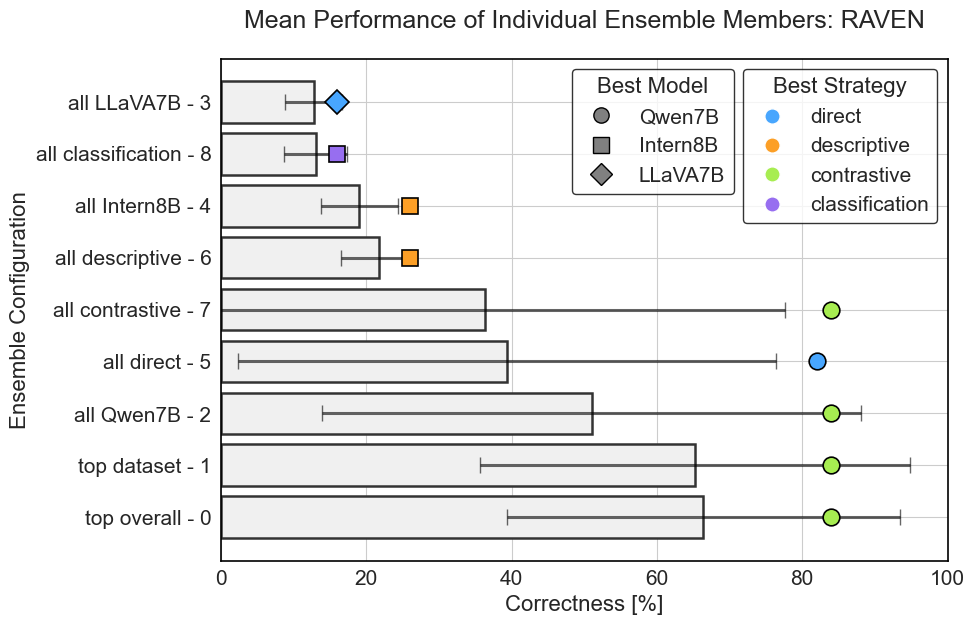

In [284]:
result = extract_best_single_per_dataset_ensemble(df)
plot_ensemble_performance_horizontal(result, dataset_name="raven")